# 隠れマルコフモデルによる呼吸相検出(説明変数：振幅・平均・差分　3種類)

# 9月22日の作業内容記載

## ライブラリのインポート  

In [1]:
import IPython.display as ipd
import pandas as pd
from scipy.io import wavfile
import os
import numpy as np
from scipy import signal
from hmmlearn import hmm
from scipy import fftpack
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import librosa
import librosa.display 
import cv2
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

### 音声ファイルの確認

In [2]:
path = '../Spectrogram/Prototype/mel_spec/'
wav_files = os.listdir('../Sound_Data/2023_proto_normal/Low')
#wav_files.remove('.DS_Store')
wav_files = sorted(wav_files)
image_files = os.listdir(path)
image_files.remove('.DS_Store')
image_files = sorted(image_files)
print(image_files)
print('----')
print(wav_files)

['3427059_Ch0_mel_spec.png', '4495349_Ch0_mel_spec.png', '7520020_Ch0_mel_spec.png', '8503185_Ch0_mel_spec.png', '9710964_Ch0_part1_mel_spec.png', '9710964_Ch0_part2_mel_spec.png', '9710964_Ch0_part3_mel_spec.png', 'cut_gray', 'gray', 'normal01_Ch0_mel_spec.png', 'normal02_Ch0_mel_spec.png', 'normal03_Ch0_mel_spec.png', 'normal04_Ch0_mel_spec.png', 'normal05_Ch0_mel_spec.png', 'normal06_Ch0_mel_spec.png', 'normal_m01_Ch0_mel_spec.png', 'normal_m02_Ch0_mel_spec.png', 'normal_m03_Ch0_mel_spec.png', 'normal_m04_Ch0_mel_spec.png']
----
['normal01_Ch0.wav', 'normal02_Ch0.wav', 'normal03_Ch0.wav', 'normal04_Ch0.wav', 'normal05_Ch0.wav', 'normal06_Ch0.wav', 'normal_m01_Ch0.wav', 'normal_m02_Ch0.wav', 'normal_m03_Ch0.wav', 'normal_m04_Ch0.wav']


## 生成する画像のファイル名の一部を定義
画像保存、読み取りの際に利用

In [3]:
f = "normal01_Ch0"
file="_mel_spec"
rename=f+"_mel_spec"
grayname=f+"_gray_mel_spec"

## 音声ファイル読み込み

In [4]:
# 音声ファイルのパスを指定します。
train_audio_path = '../Sound_Data/2023_proto_normal/Low/'
# 初期設定値
filename = f+'.wav' #wavファイル名
disease = f #受診者の肺音の症状
save_flag = 0 #スペクトログラム画像の保存　0:保存しない　1:保存
axis = 1 #軸とサイズ　0:軸なし、サイズ(1584, 256)　1:軸あり、サイズ比(24, 4)　2:軸なし、サイズデフォルト　3:軸あり、サイズデフォルト

name = filename[0:-4] #拡張子抜きファイル名
rate = 10000

# 音声データの読み込み
# sample_rate:サンプリング周波数, sample:サンプルwavデータ
sample_rate, samples = wavfile.read(train_audio_path + filename)
# Player 実行 モノラルではなくステレオなので配列の向きの違いから転置の必要あり
ipd.Audio(samples.T, rate=sample_rate)

In [5]:
samples, sample_rate = librosa.load(str(train_audio_path) + filename, sr=rate, mono=False)

### 音声ファイル情報　表示

In [6]:
N = samples.shape[0] # 標本データ数(要素数)を返す
L = len(samples)/sample_rate # 時間(長さ)の算出
padding_list = (sample_rate*20-N)*[0]
plot_time = np.linspace(0, L, N) # グラフ描画のための時間軸の生成


print("file_name:\t"+str(filename))
print("disease:\t"+str(disease))
print("name:\t\t"+str(name))
print("サンプリング周波数:"+str(sample_rate))
print("標本数:\t\t"+str(N))
print("総時間:\t\t"+str(L))
print("データの型:\t"+str(samples.dtype))
print("セグメント:\t"+str(L/132))
print("チャンネル数:\t"+str(samples.ndim))
print("追加の標本数:\t"+str(len(padding_list)))
print("20秒の標本数:\t"+str(sample_rate*20))

file_name:	normal01_Ch0.wav
disease:	normal01_Ch0
name:		normal01_Ch0
サンプリング周波数:10000
標本数:		150000
総時間:		15.0
データの型:	float32
セグメント:	0.11363636363636363
チャンネル数:	1
追加の標本数:	50000
20秒の標本数:	200000


## librosaによる音声ファイル読み込み（テスト用）

In [7]:
test_wave_list = []
test_wave_time = []
fs_test = 10000
for i in wav_files:
    wave_test, fs_test = librosa.load(train_audio_path + i, sr=10000, mono=True)
    
    N_test = wave_test.shape[0] # 標本データ数(要素数)を返す
    L_test = len(wave_test)/fs_test # 時間(長さ)の算出
    time = np.linspace(0, L_test, N_test) # グラフ描画のための時間軸の生成
    print(time[-1])
    
    
    test_wave_time.append(time)
    test_wave_list.append(wave_test)
    print(i)

15.0
normal01_Ch0.wav
20.0
normal02_Ch0.wav
20.0
normal03_Ch0.wav
20.0
normal04_Ch0.wav
20.0
normal05_Ch0.wav
20.0
normal06_Ch0.wav
15.0
normal_m01_Ch0.wav
15.0
normal_m02_Ch0.wav
15.0
normal_m03_Ch0.wav
15.0
normal_m04_Ch0.wav


## スペクトログラム画像を用いた低周波数信号の算出

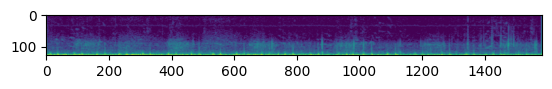

In [167]:
im_dif = cv2.imread(path+"normal06_Ch0_mel_spec.png")
im_gray = cv2.cvtColor(im_dif, cv2.COLOR_BGR2GRAY)
im_cut = im_gray[128:257,:]
ex = im_cut[110,:]
ex = ex.astype(np.float32)
plt.imshow(im_cut)

In [9]:
(1584/4)*3

1188.0

In [10]:
15/(20.0/1584)

1188.0

## 音声ファイルプロット

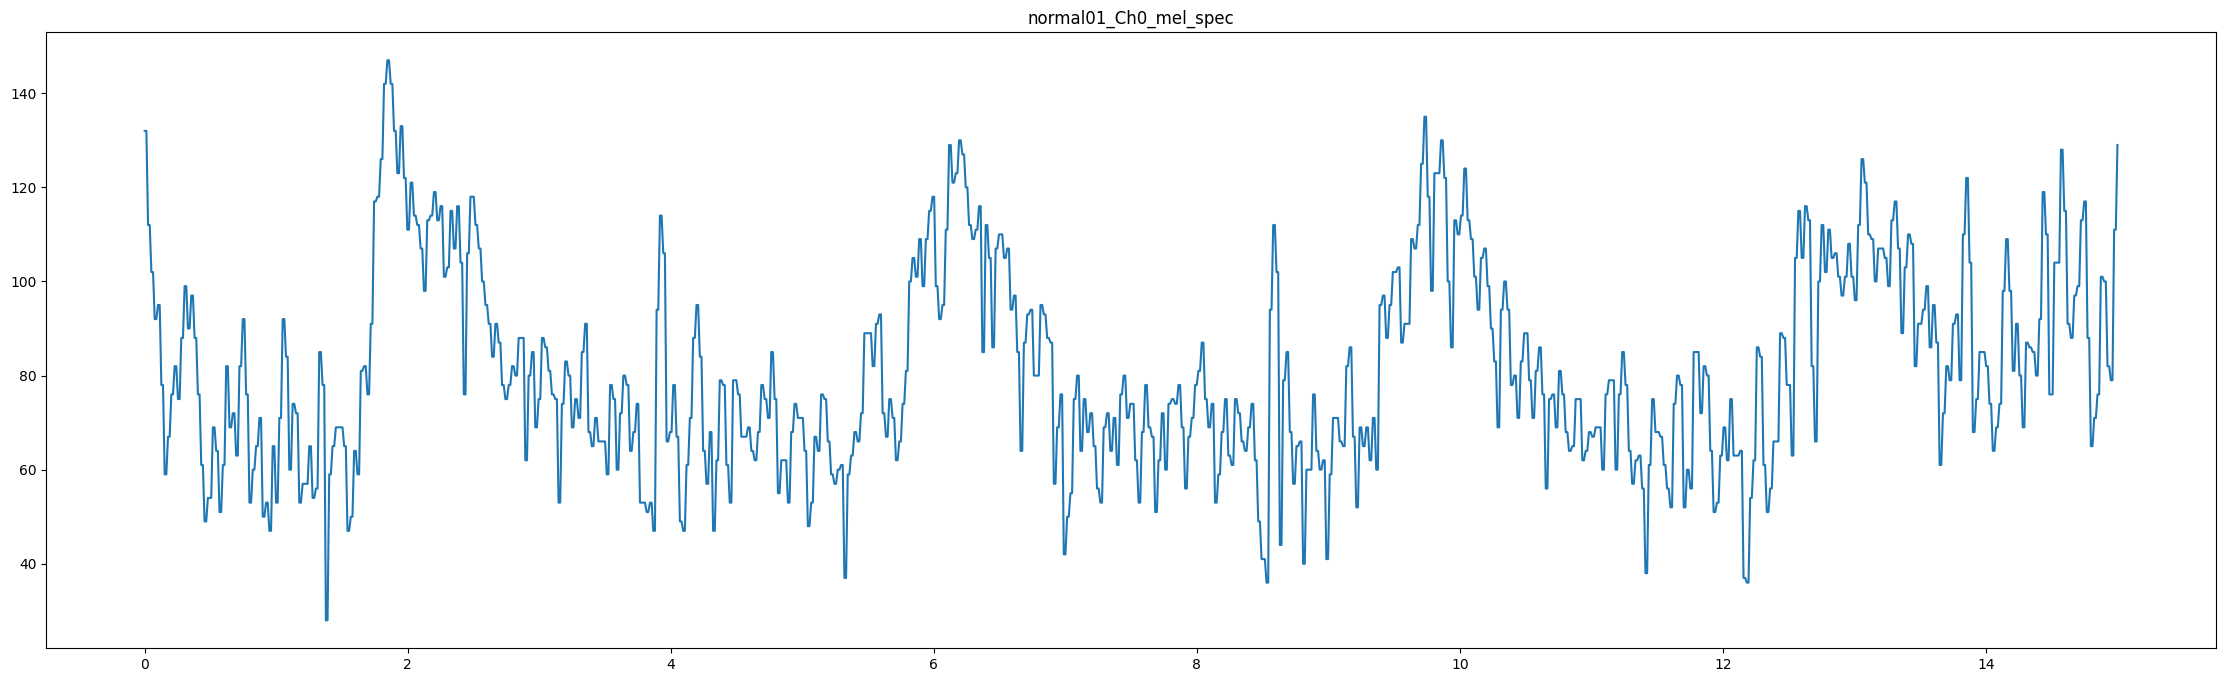

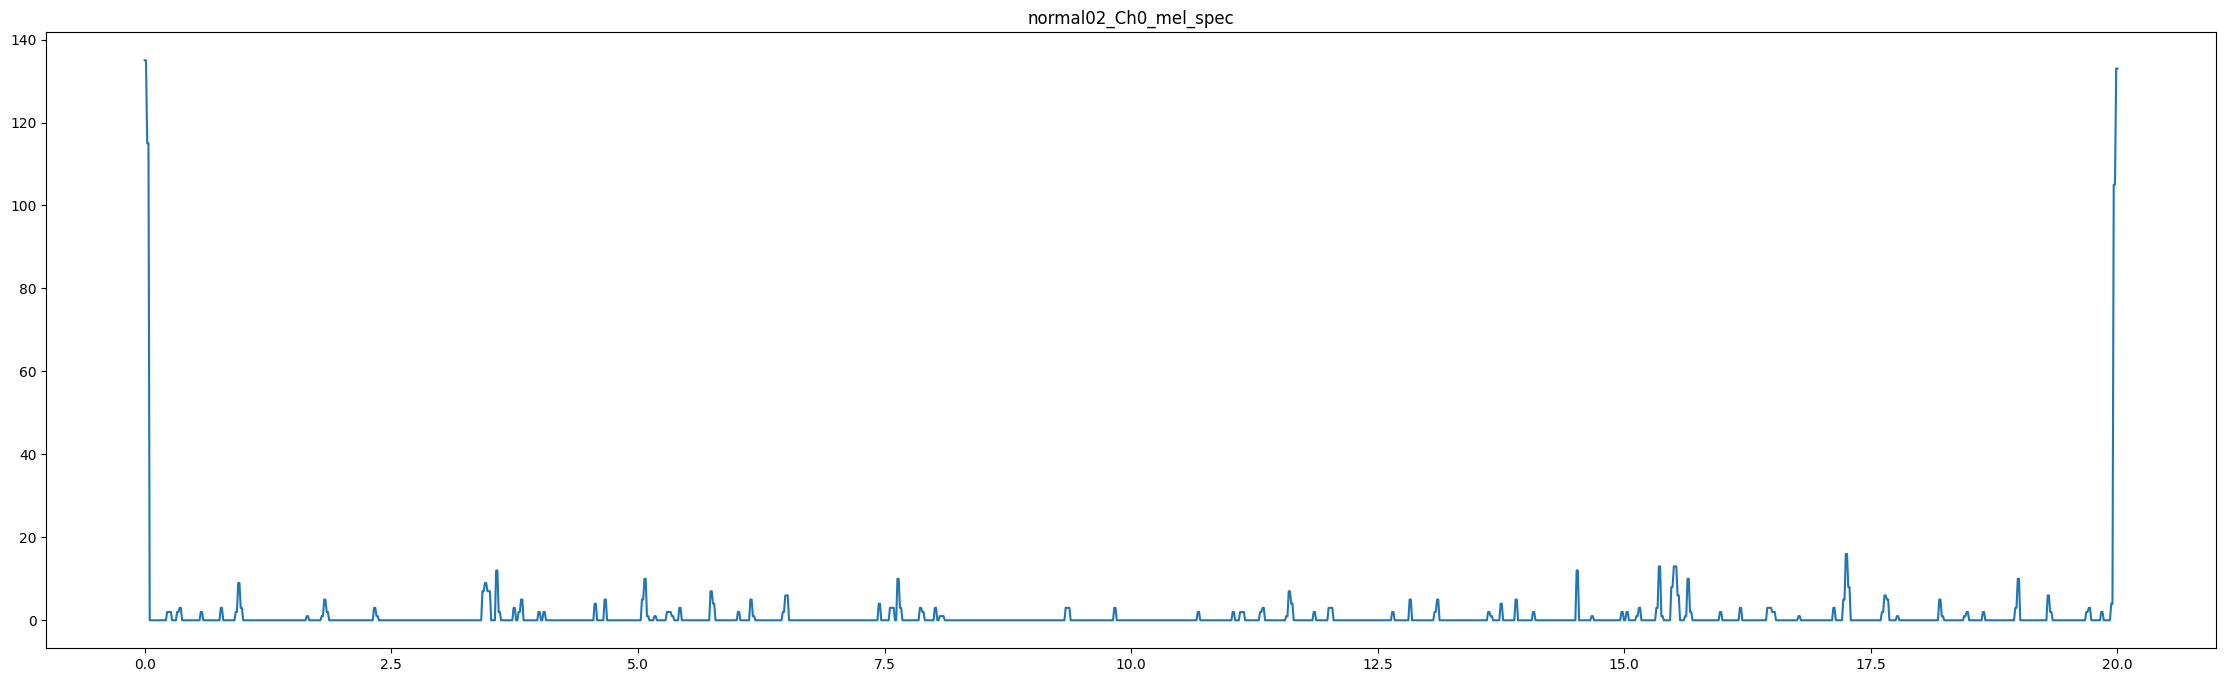

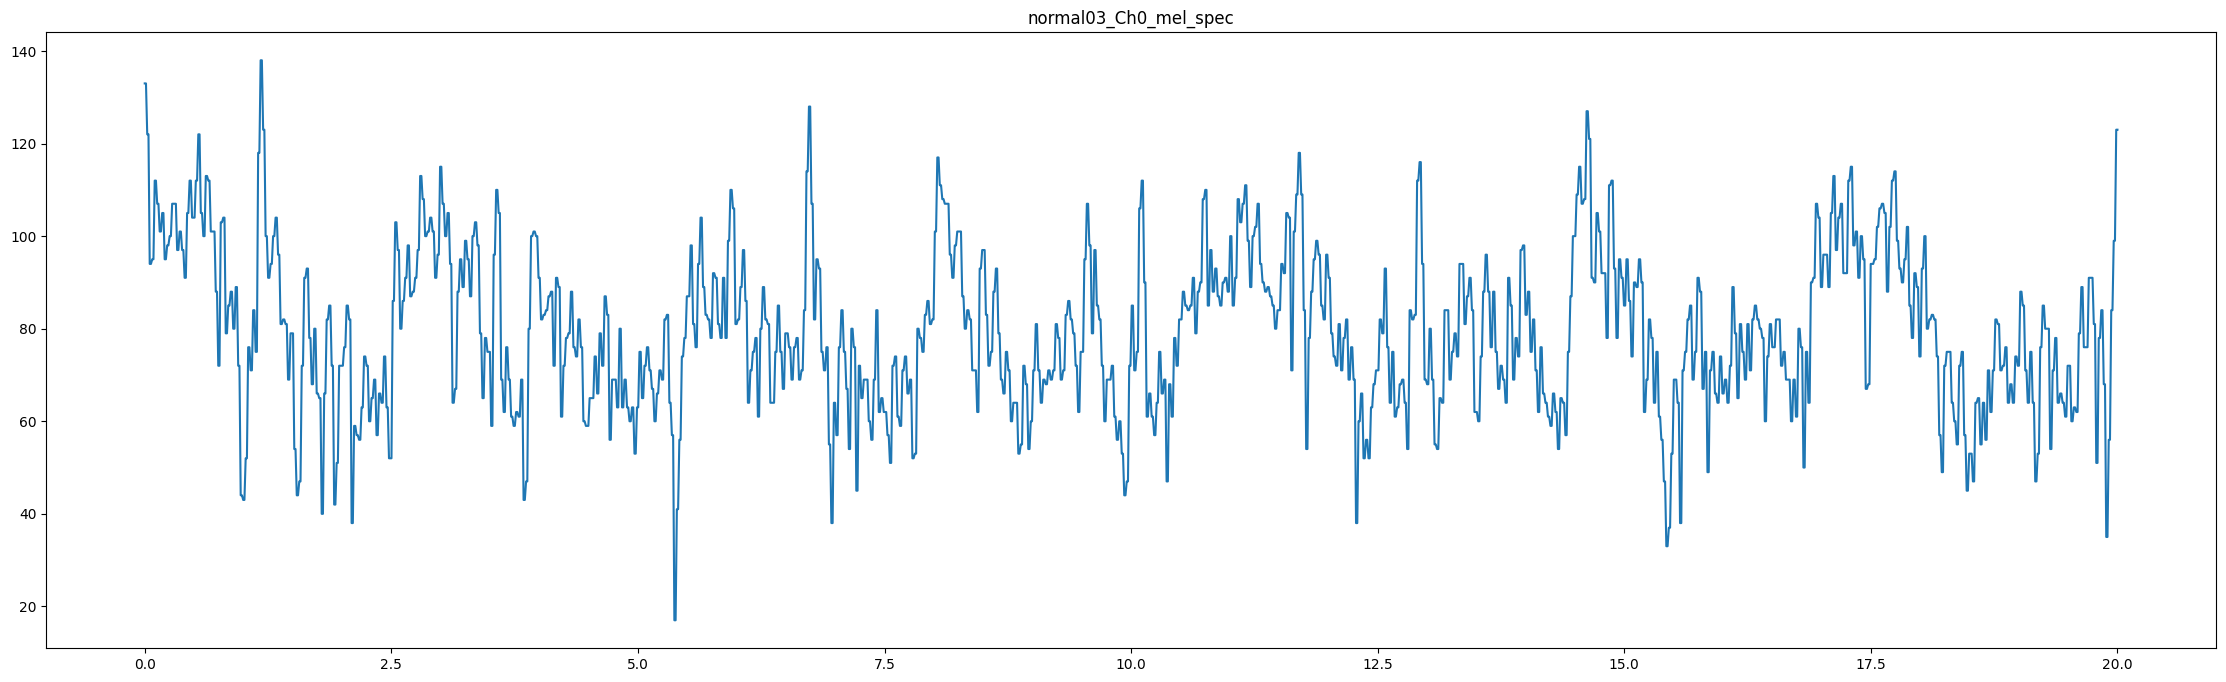

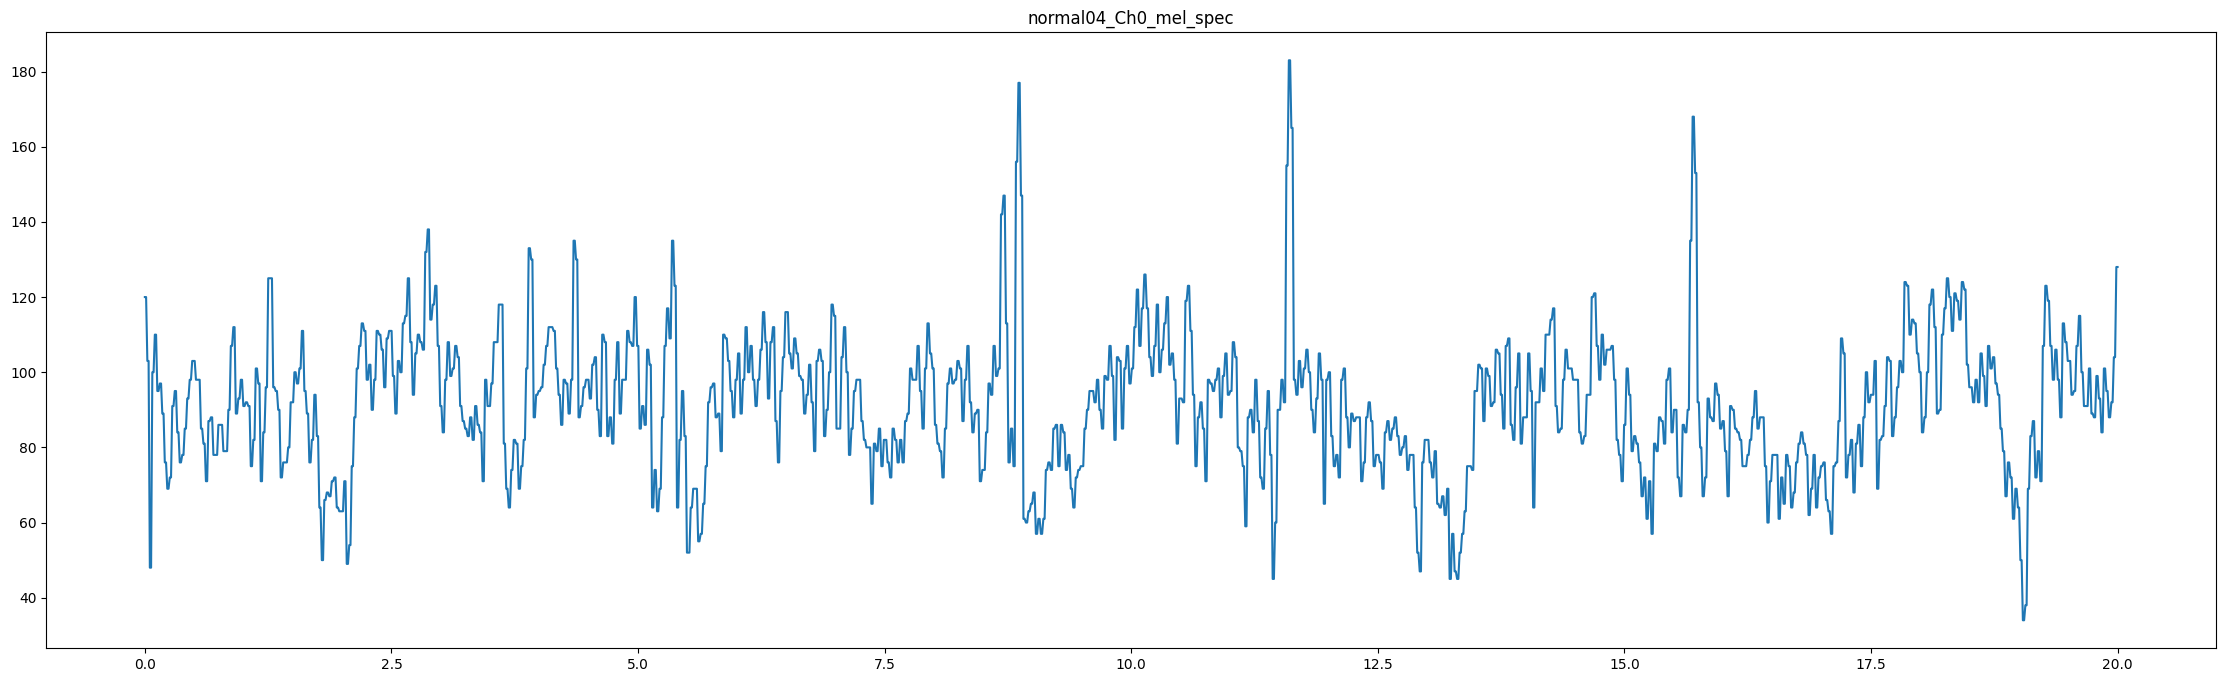

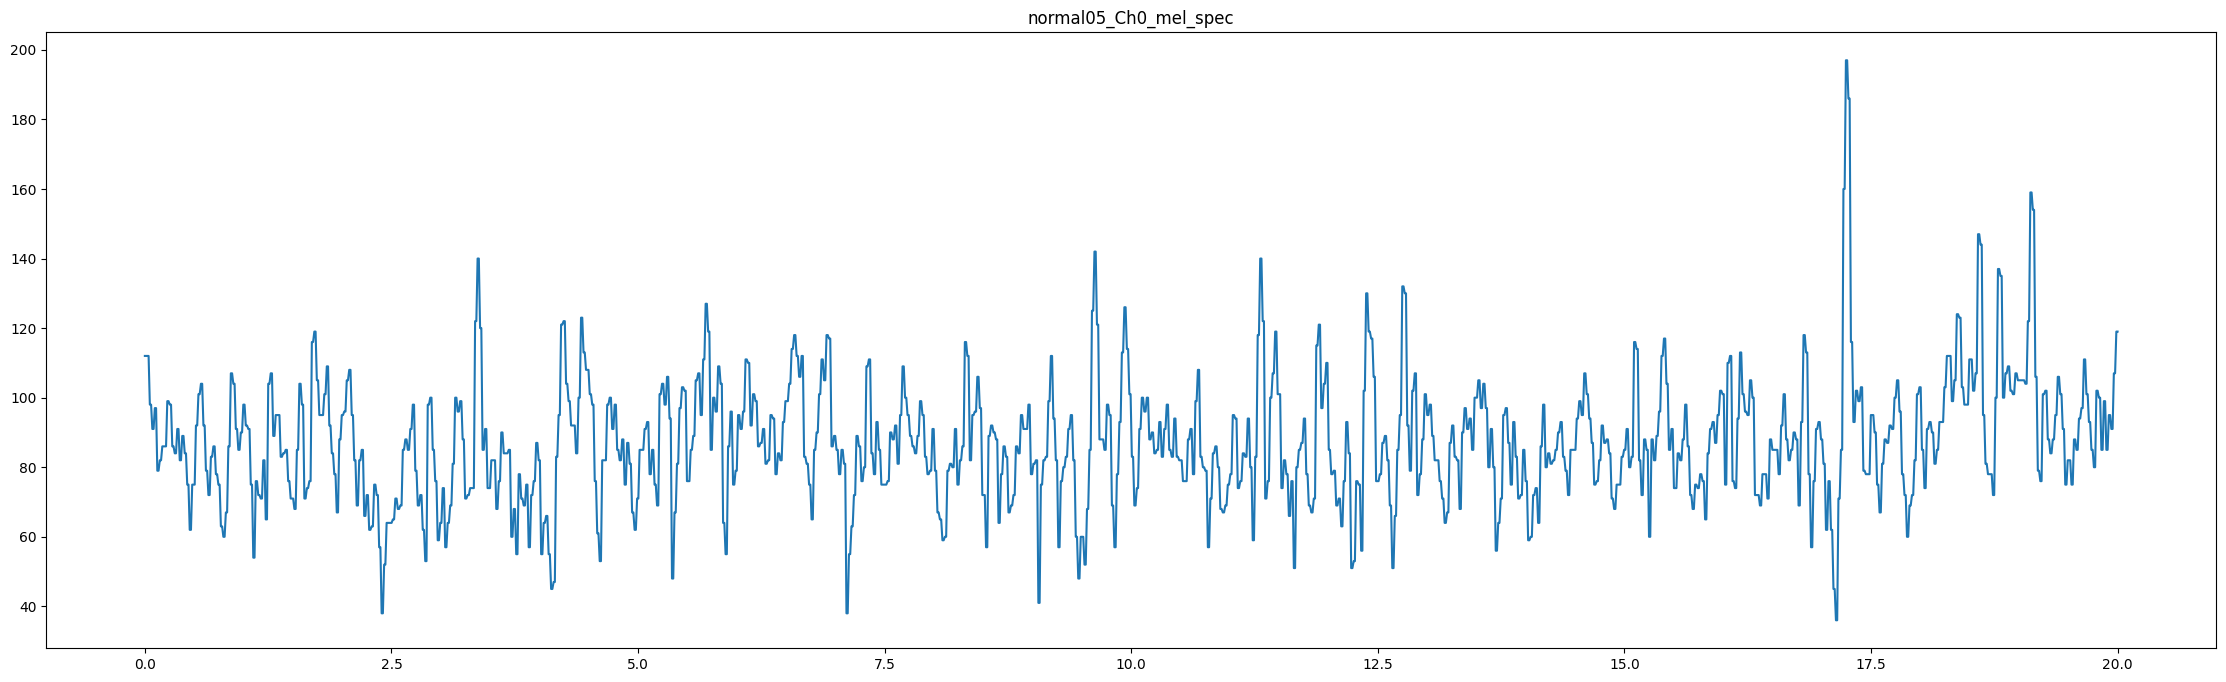

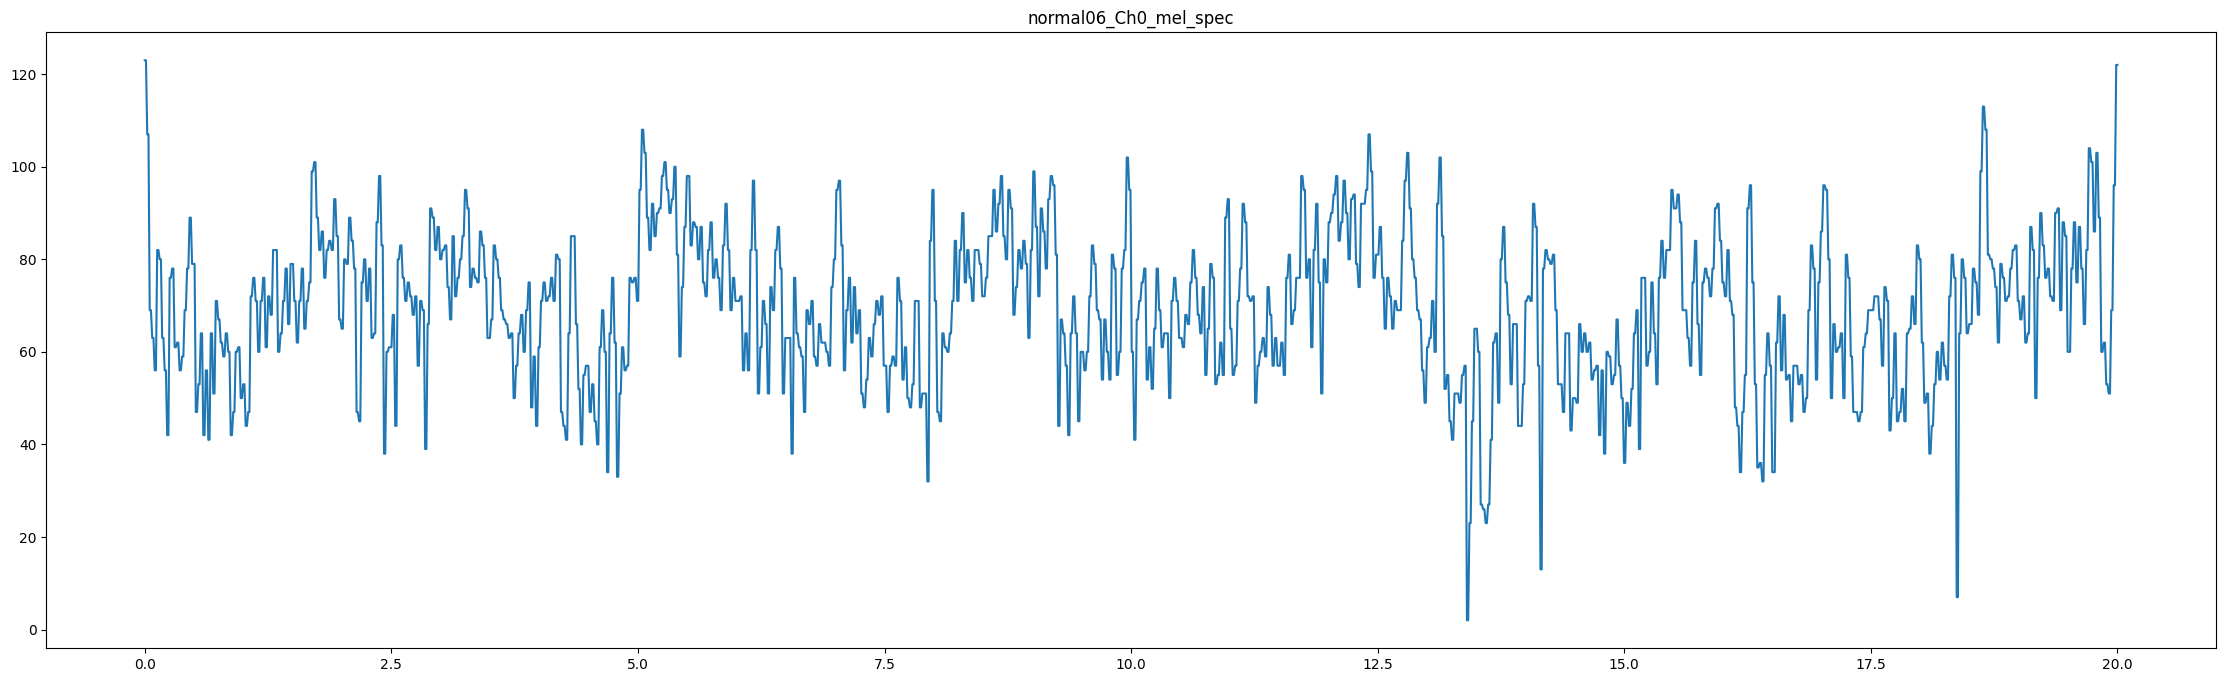

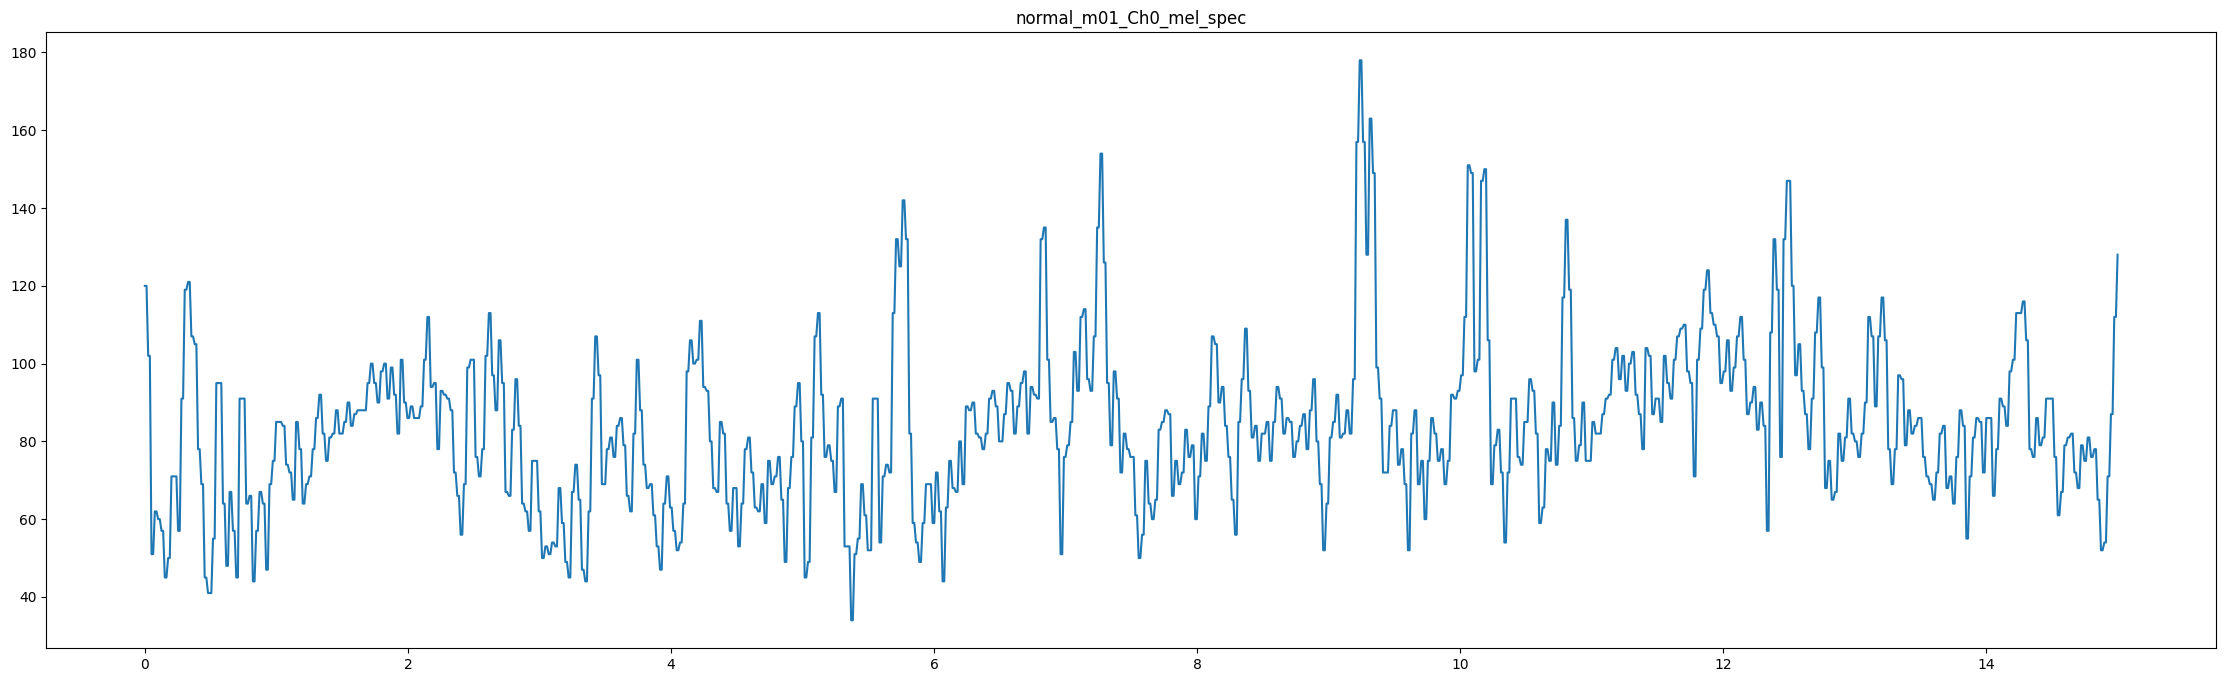

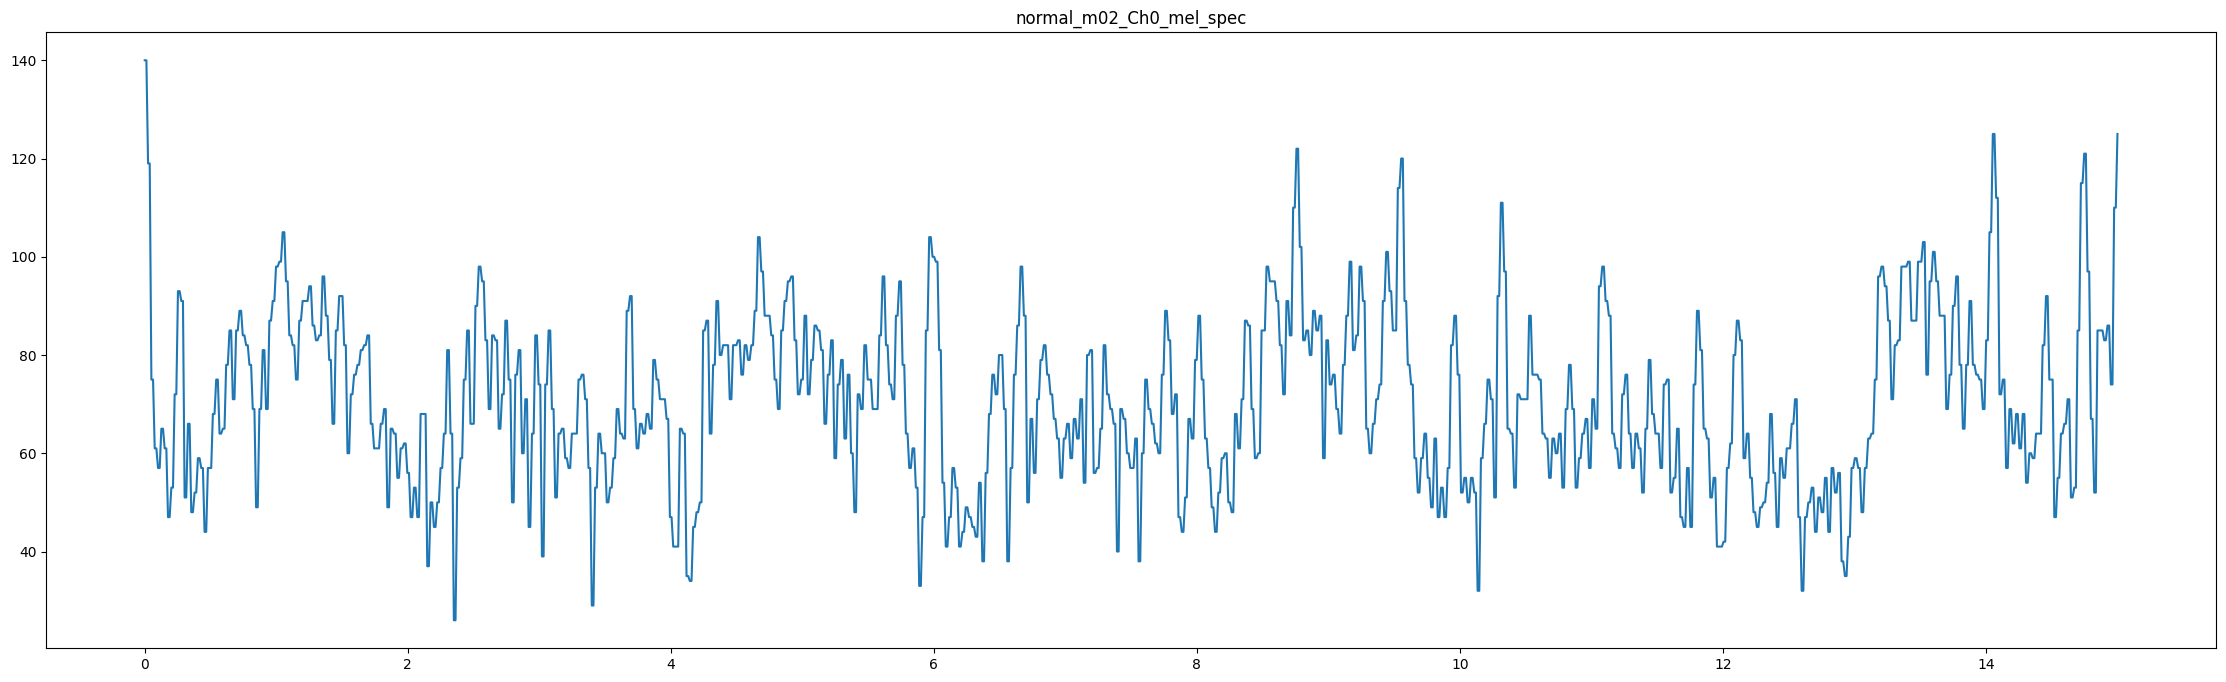

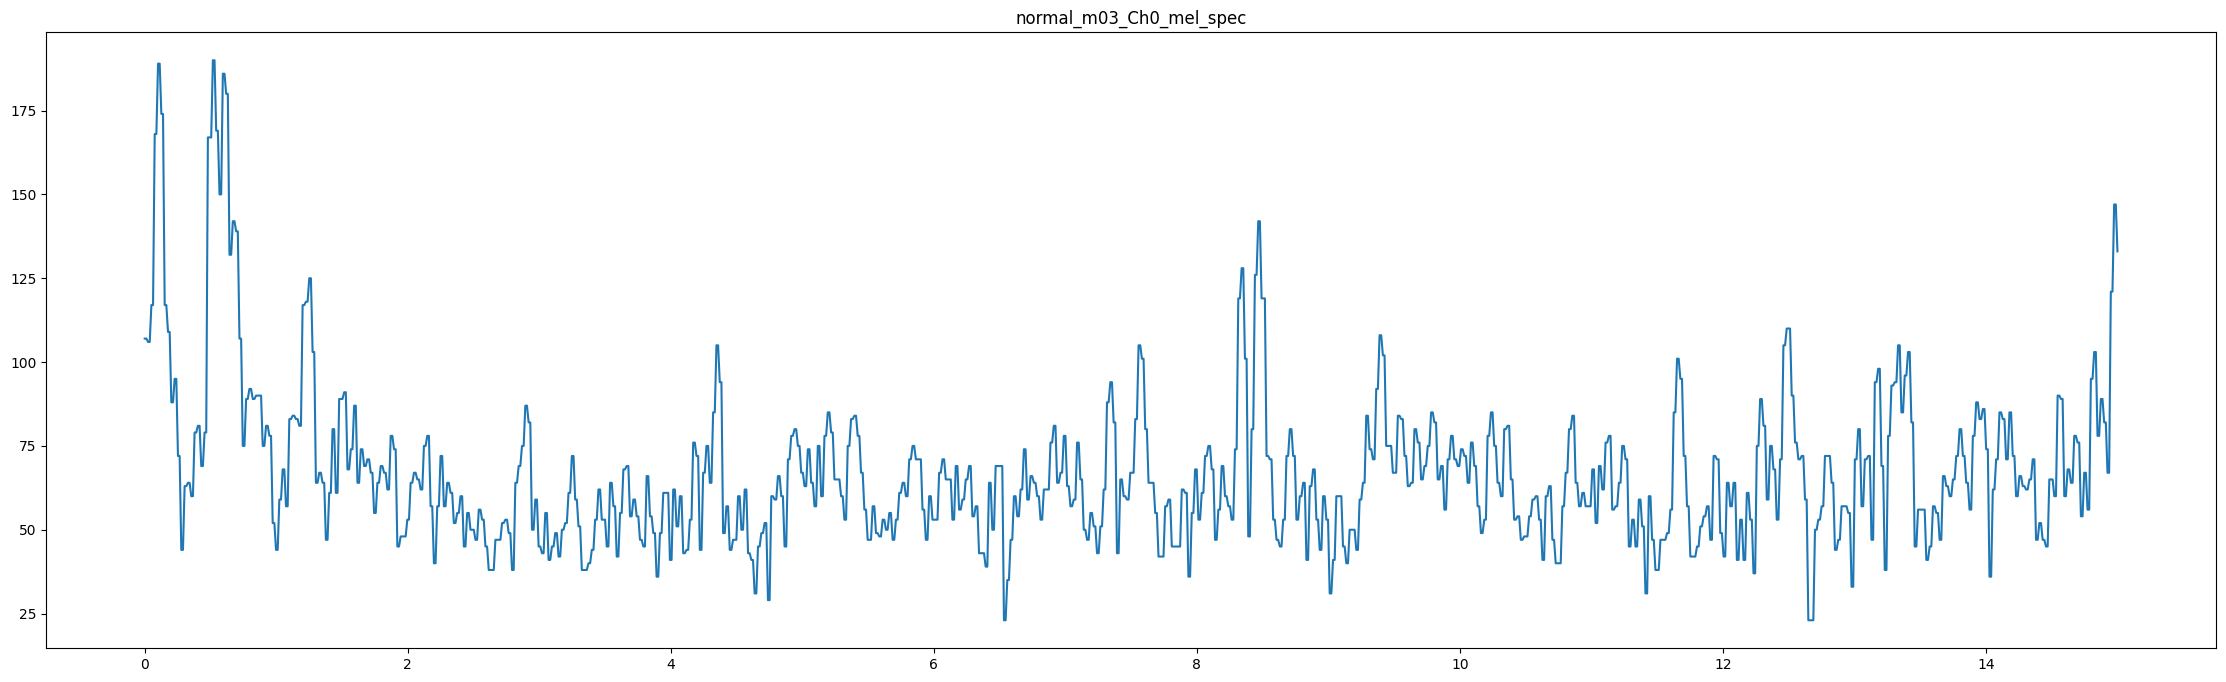

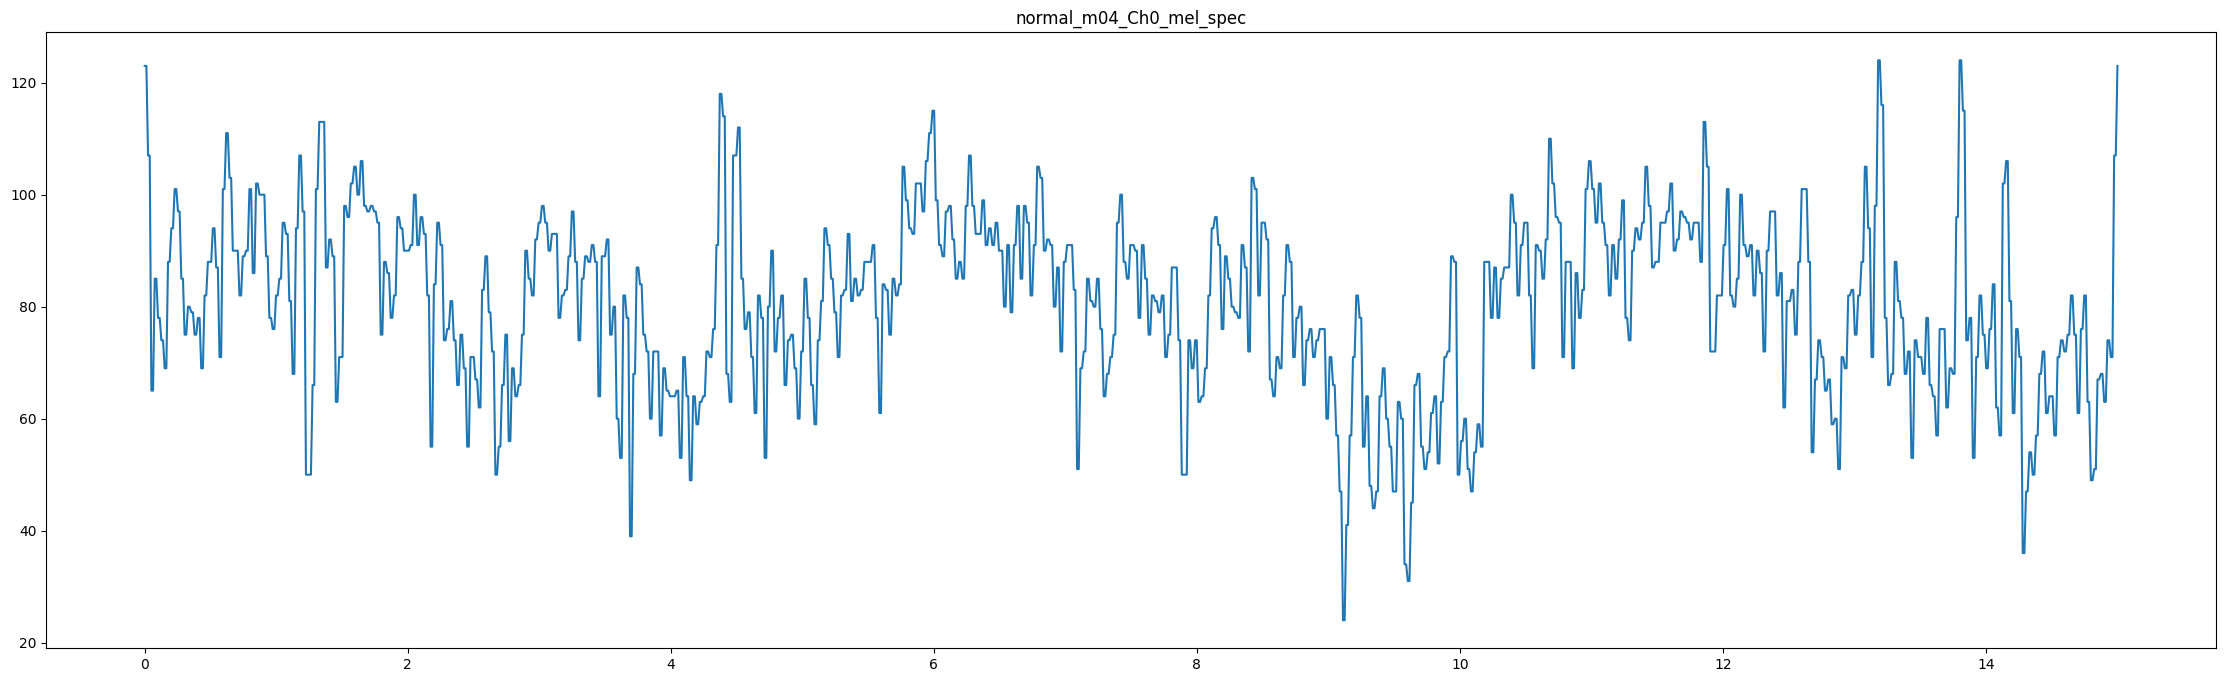

In [11]:
spec_wave_list = []
spec_wave_time = []
fs_spec_list = []


for j,i in enumerate(wav_files):
    
    im_dif = cv2.imread(path+i[0:-4]+file+".png")
    im_gray = cv2.cvtColor(im_dif, cv2.COLOR_BGR2GRAY)
    im_cut = im_gray[128:257,:]
    ex = im_cut[110,:]#115
    ex = ex.astype(np.float32)
    
    #print(test_wave_time[j][-1])
    if test_wave_time[j][-1]==15.0:
        N_spec = 150000#ex.shape[0] # 標本データ数(要素数)を返す
        L_spec = 15.0#test_wave_time[j][-1] # 時間(長さ)の算出
        spec_time_axis = np.linspace(0, 15.0, int(15/(20.0/1584)))
        ex = ex[0:int(15/(20.0/1584))]
        
    elif test_wave_time[j][-1]==20.0:
        N_spec = 200000#ex.shape[0] # 標本データ数(要素数)を返す
        L_spec = 20.0#test_wave_time[j][-1] # 時間(長さ)の算出
        spec_time_axis = np.linspace(0, 20.0, 1584)
    
    x = np.linspace(0, L_spec, N_spec)
    fs_spec = 1/(L_spec/N_spec)
    
    spec_wave_list.append(ex)
    spec_wave_time.append(x)
    fs_spec_list.append(fs_spec)
    
    fig, ax = plt.subplots(figsize=(28, 8))
    ax.set_title(i[0:-4]+file)
    plt.plot(spec_time_axis,ex)

## 低周波数のrms信号算出

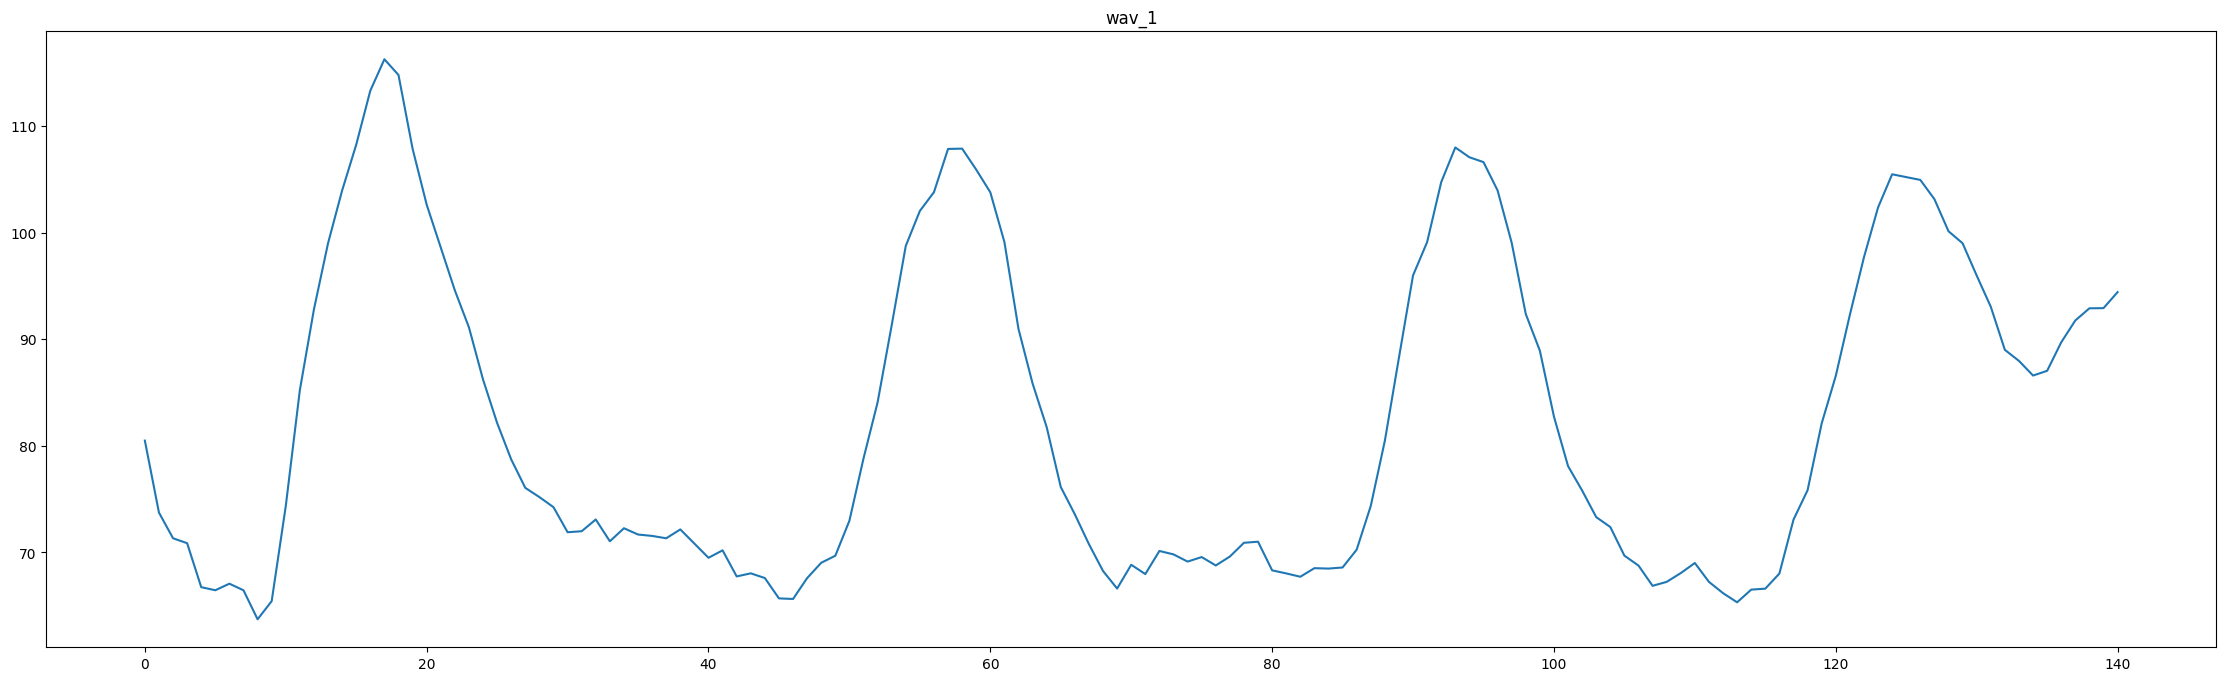

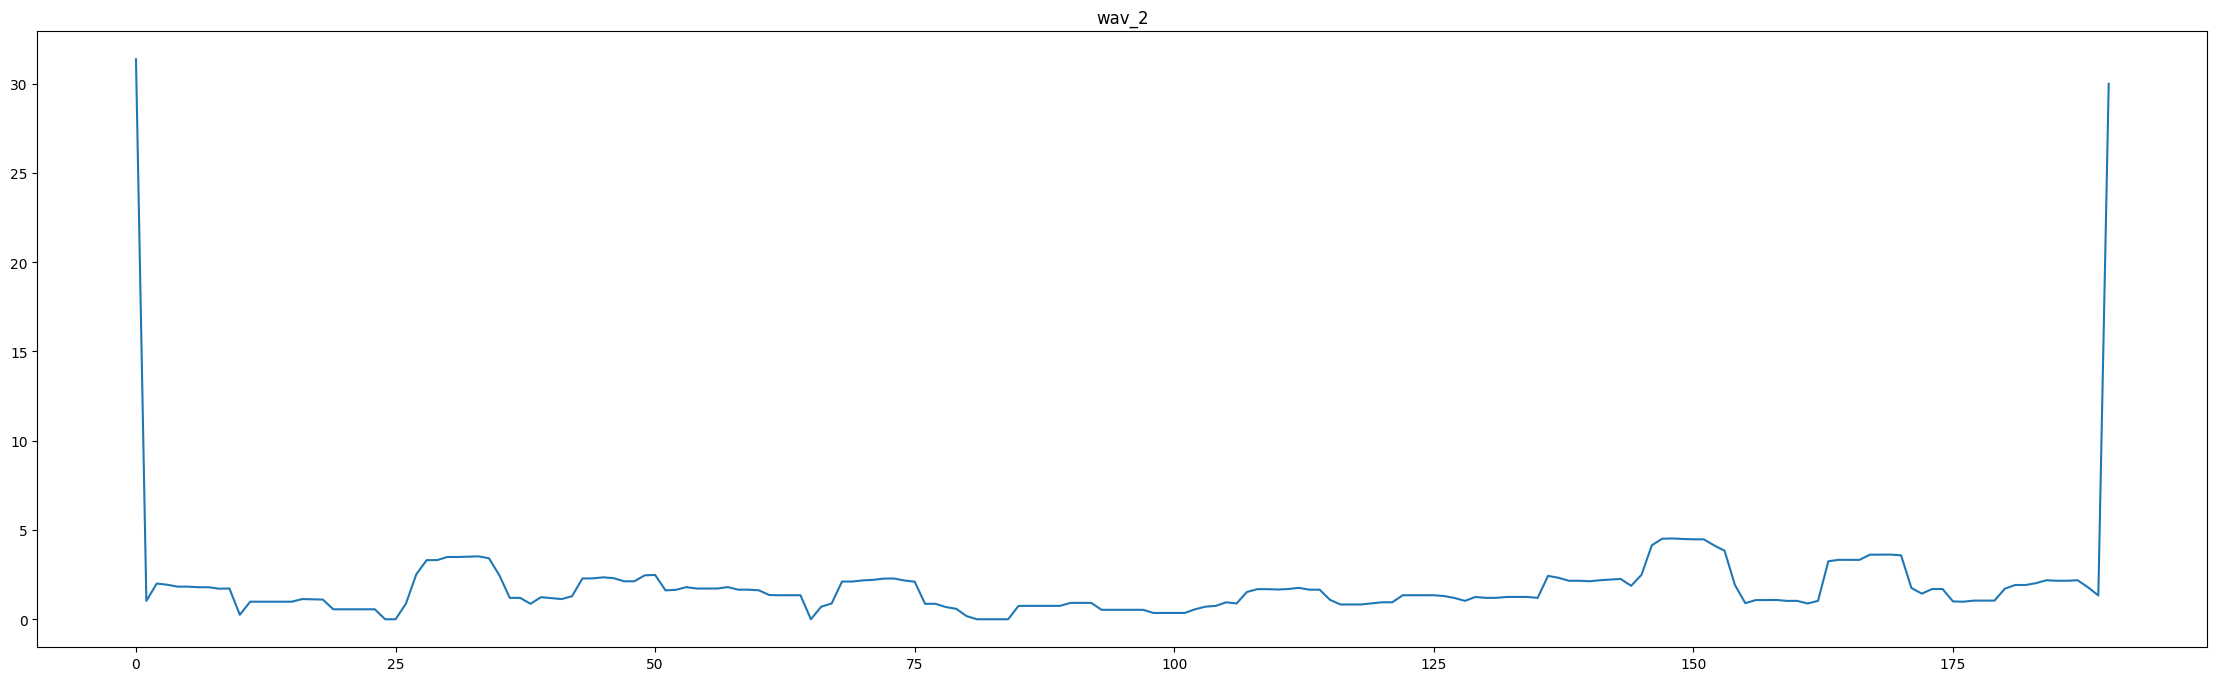

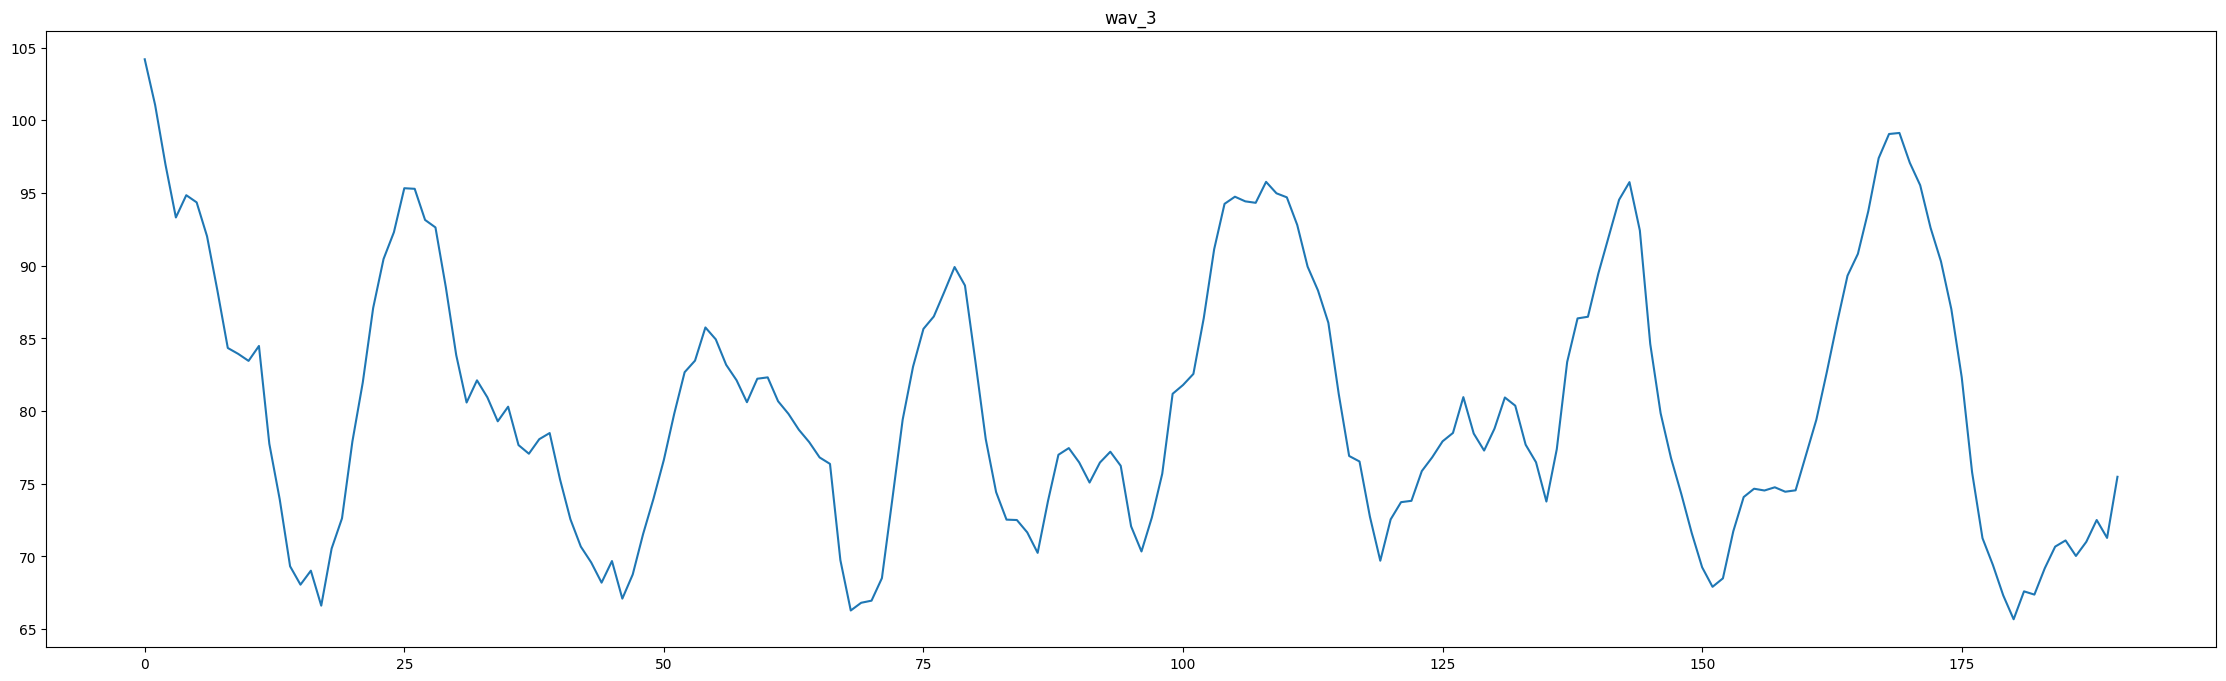

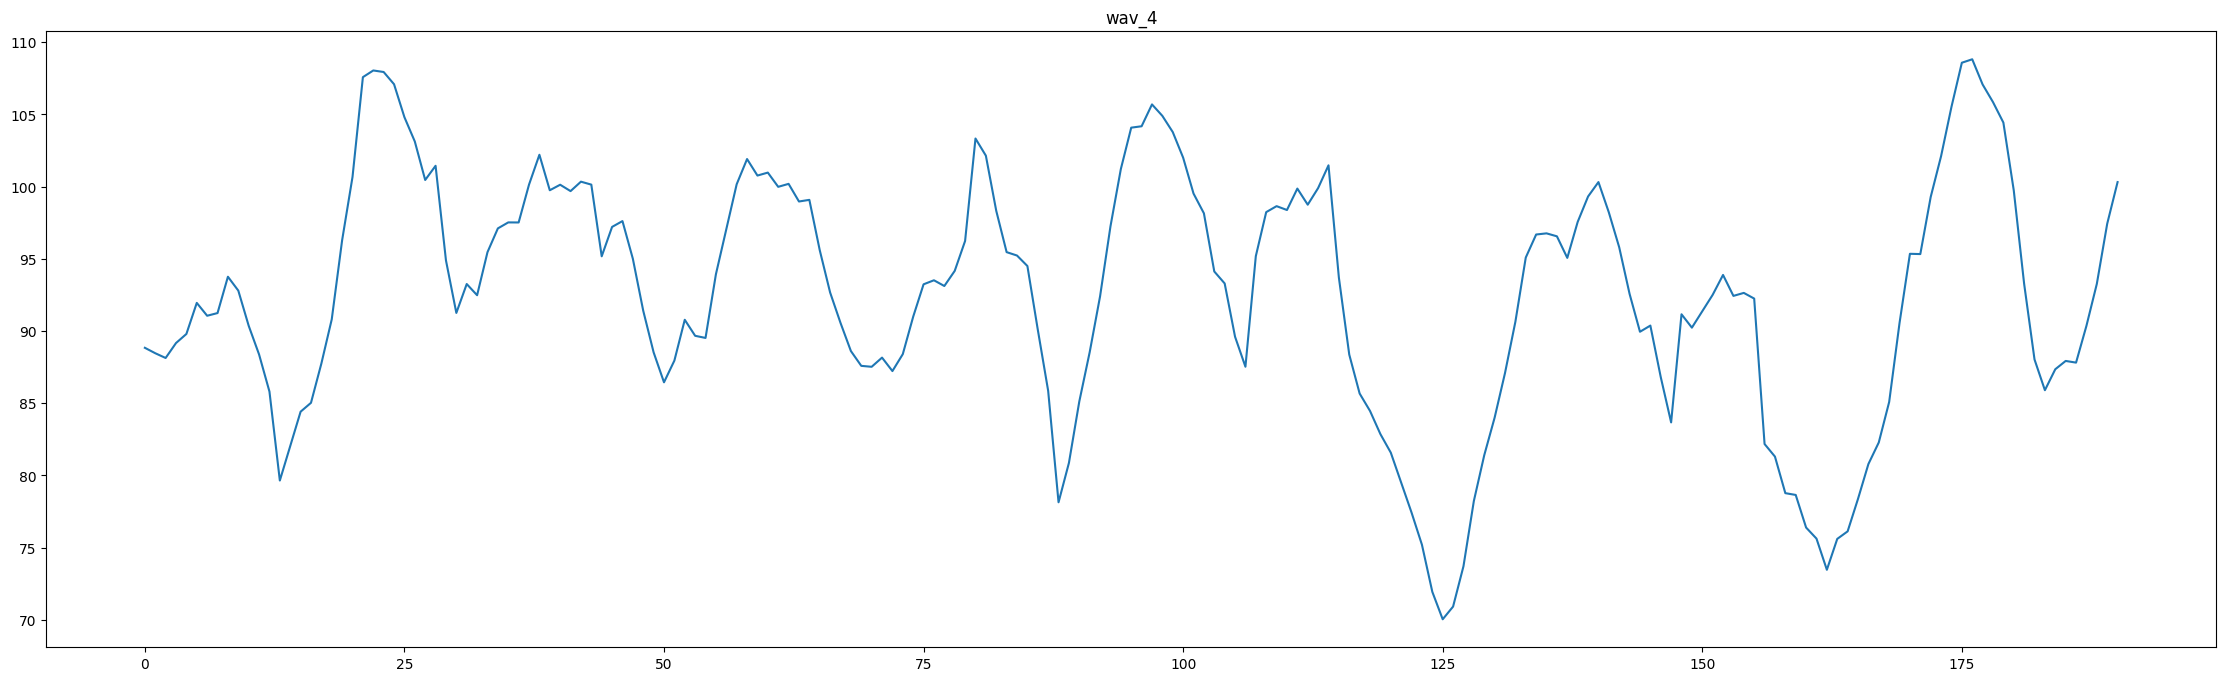

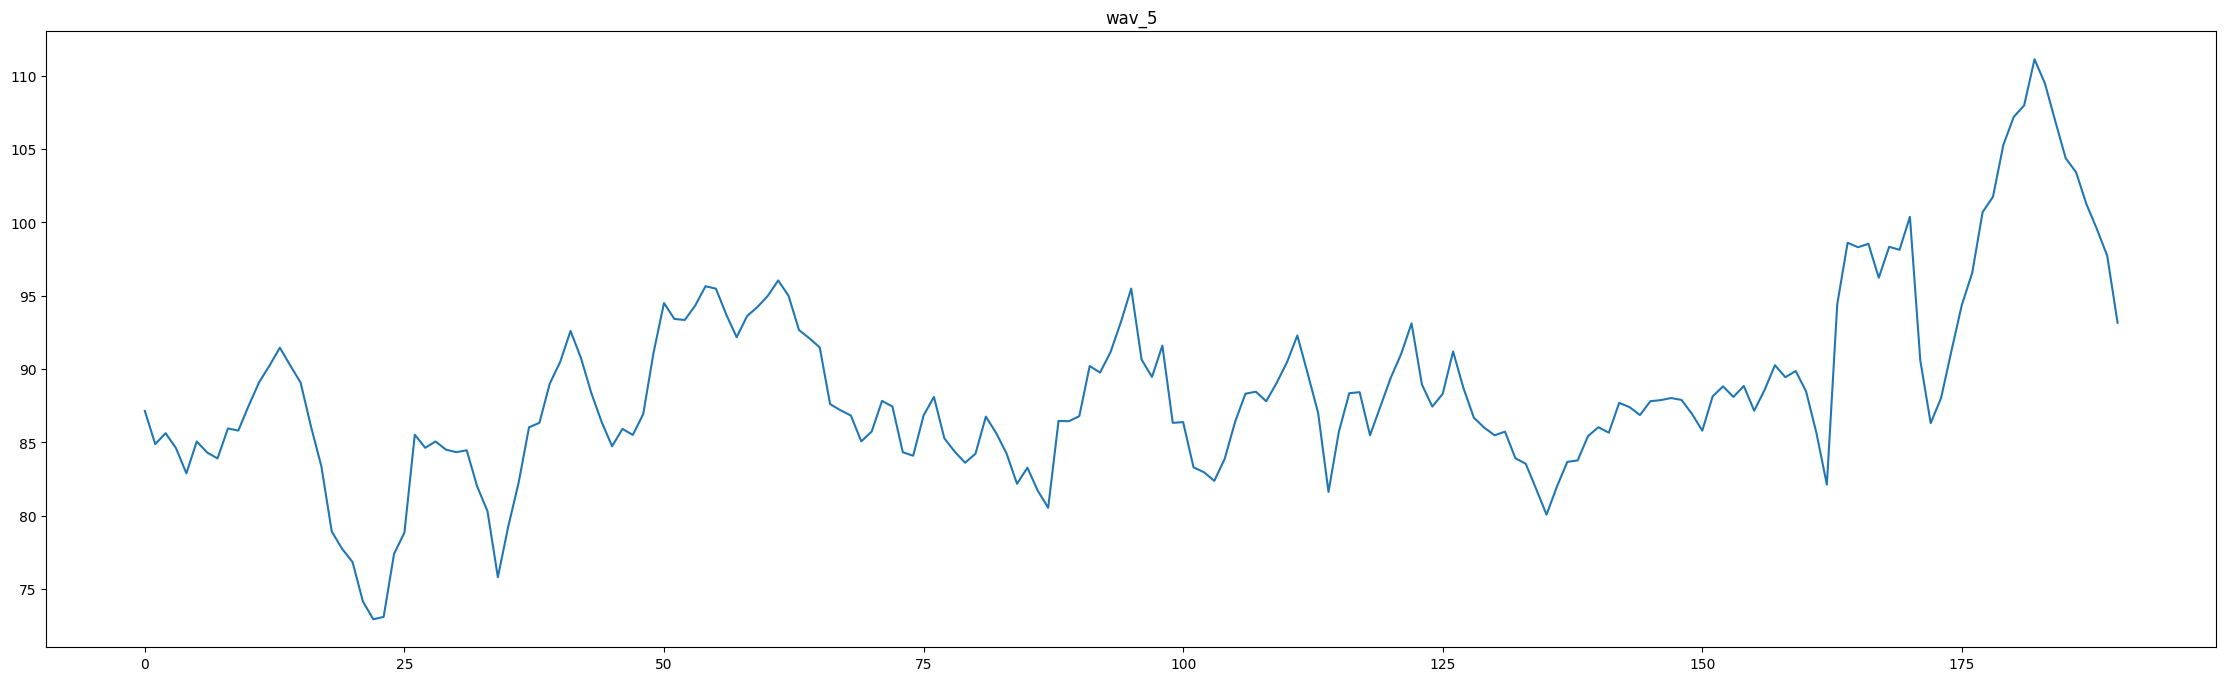

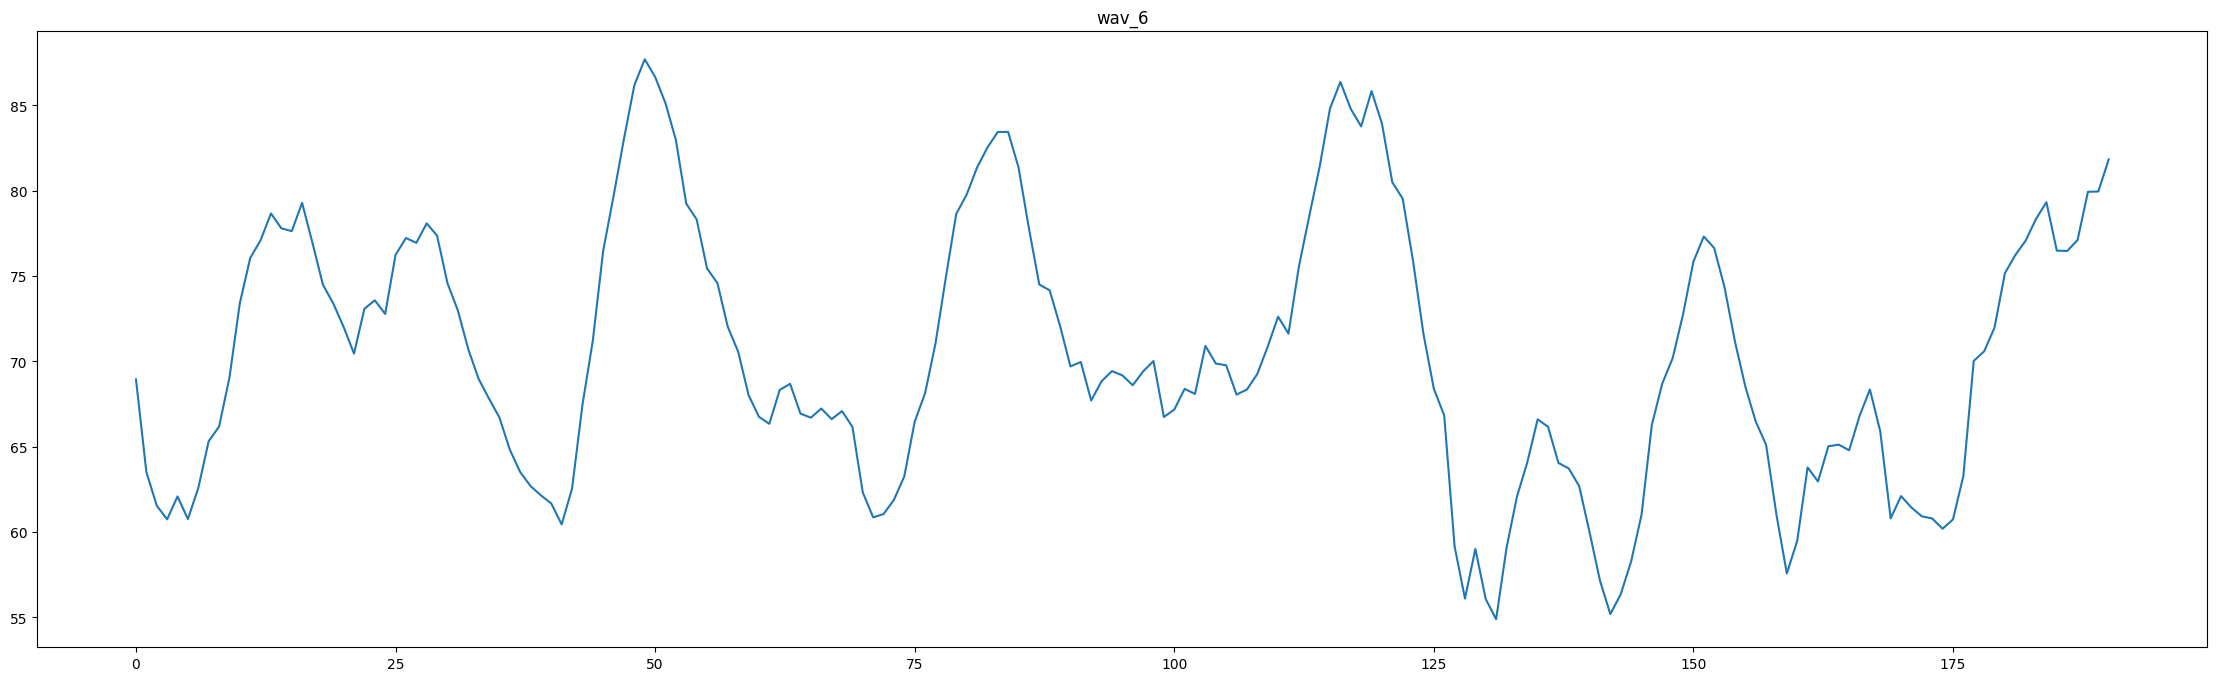

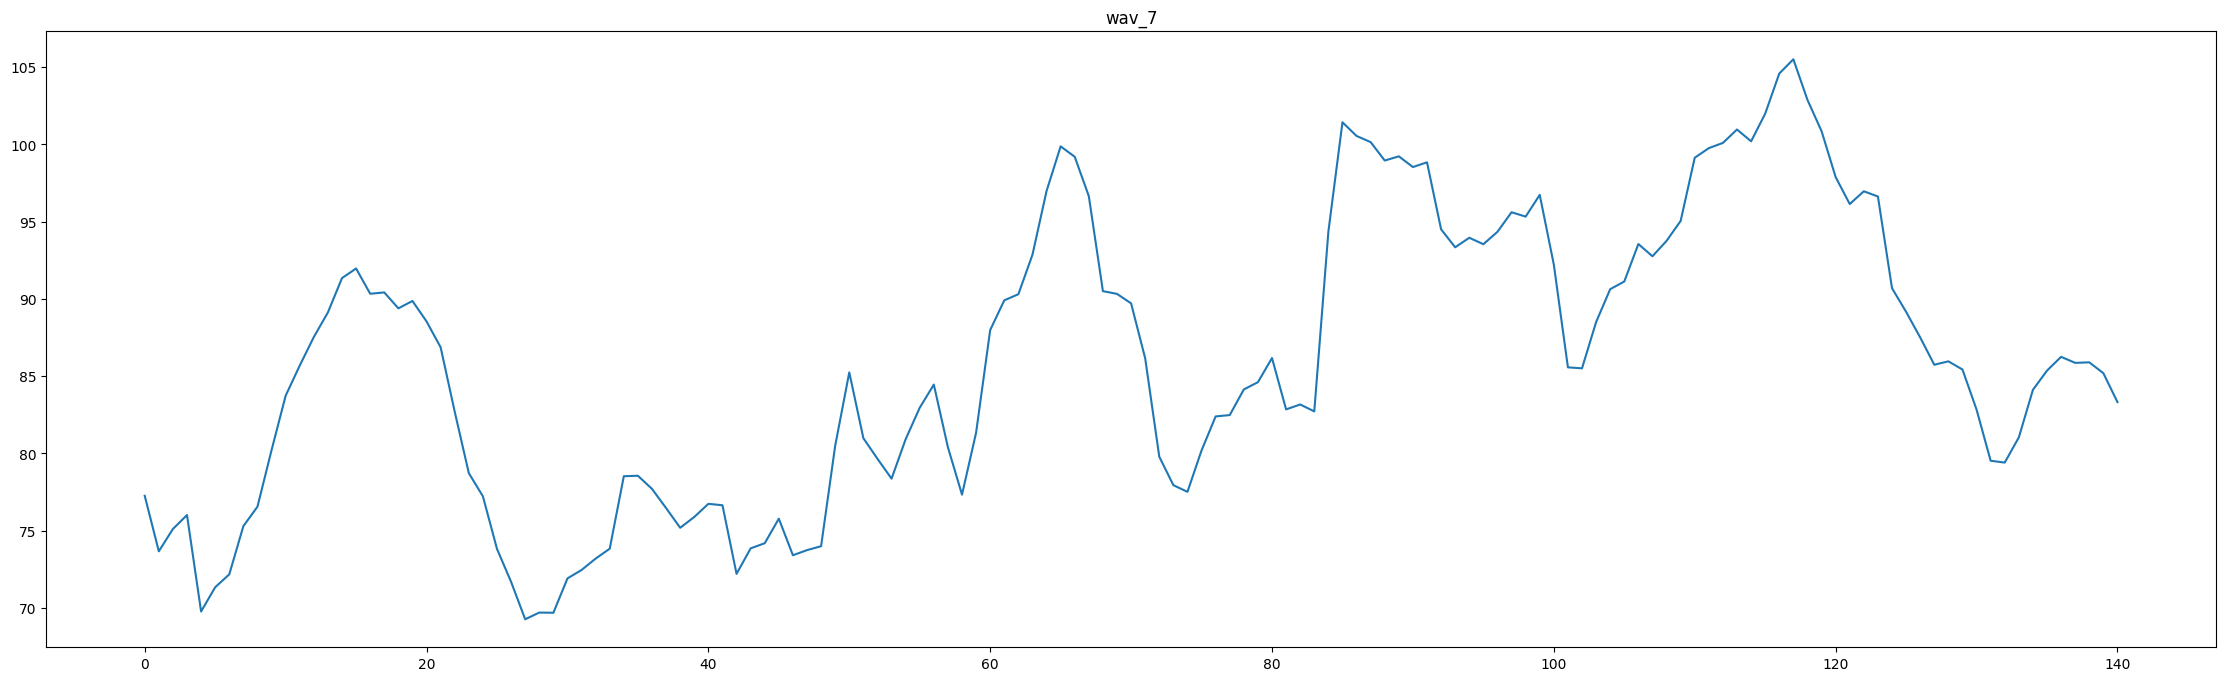

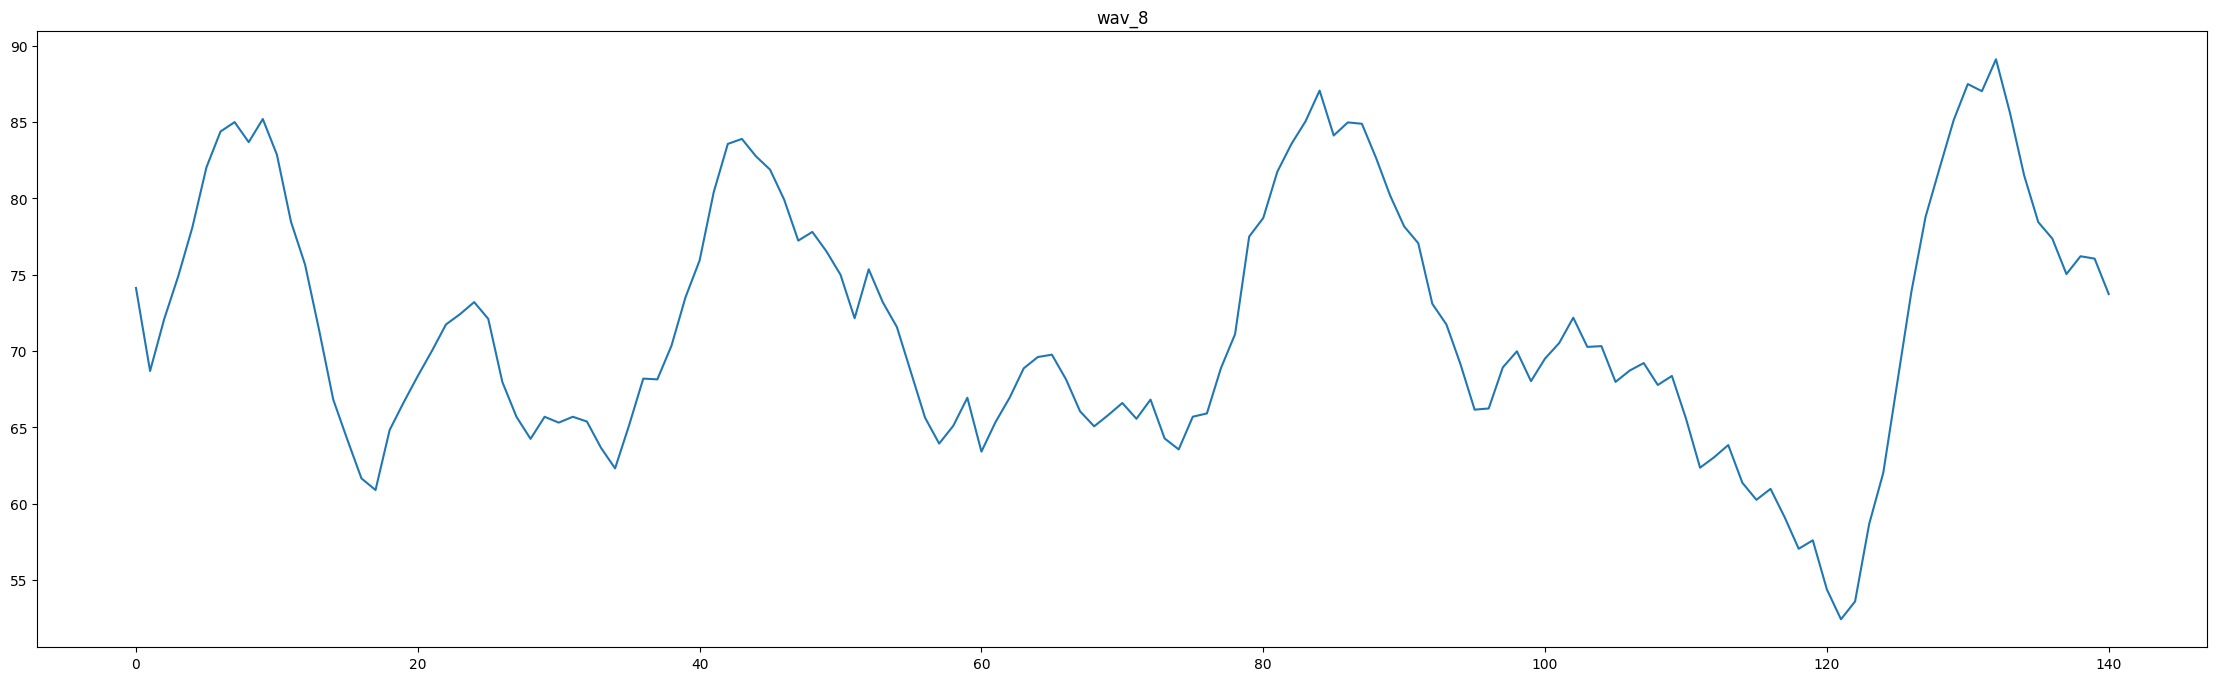

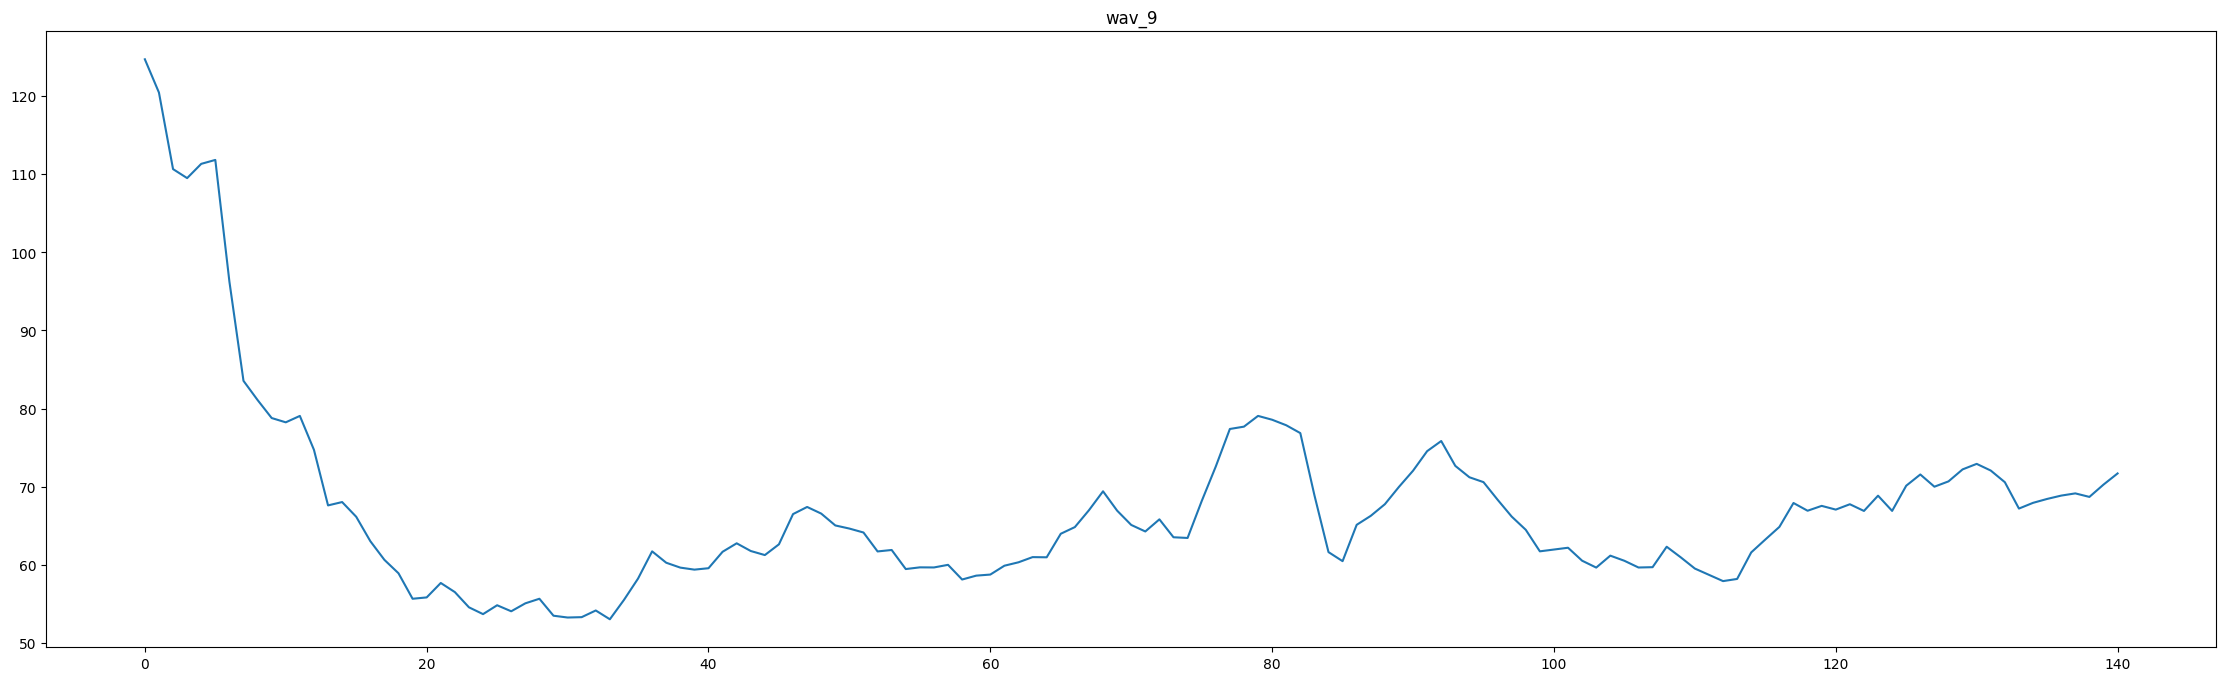

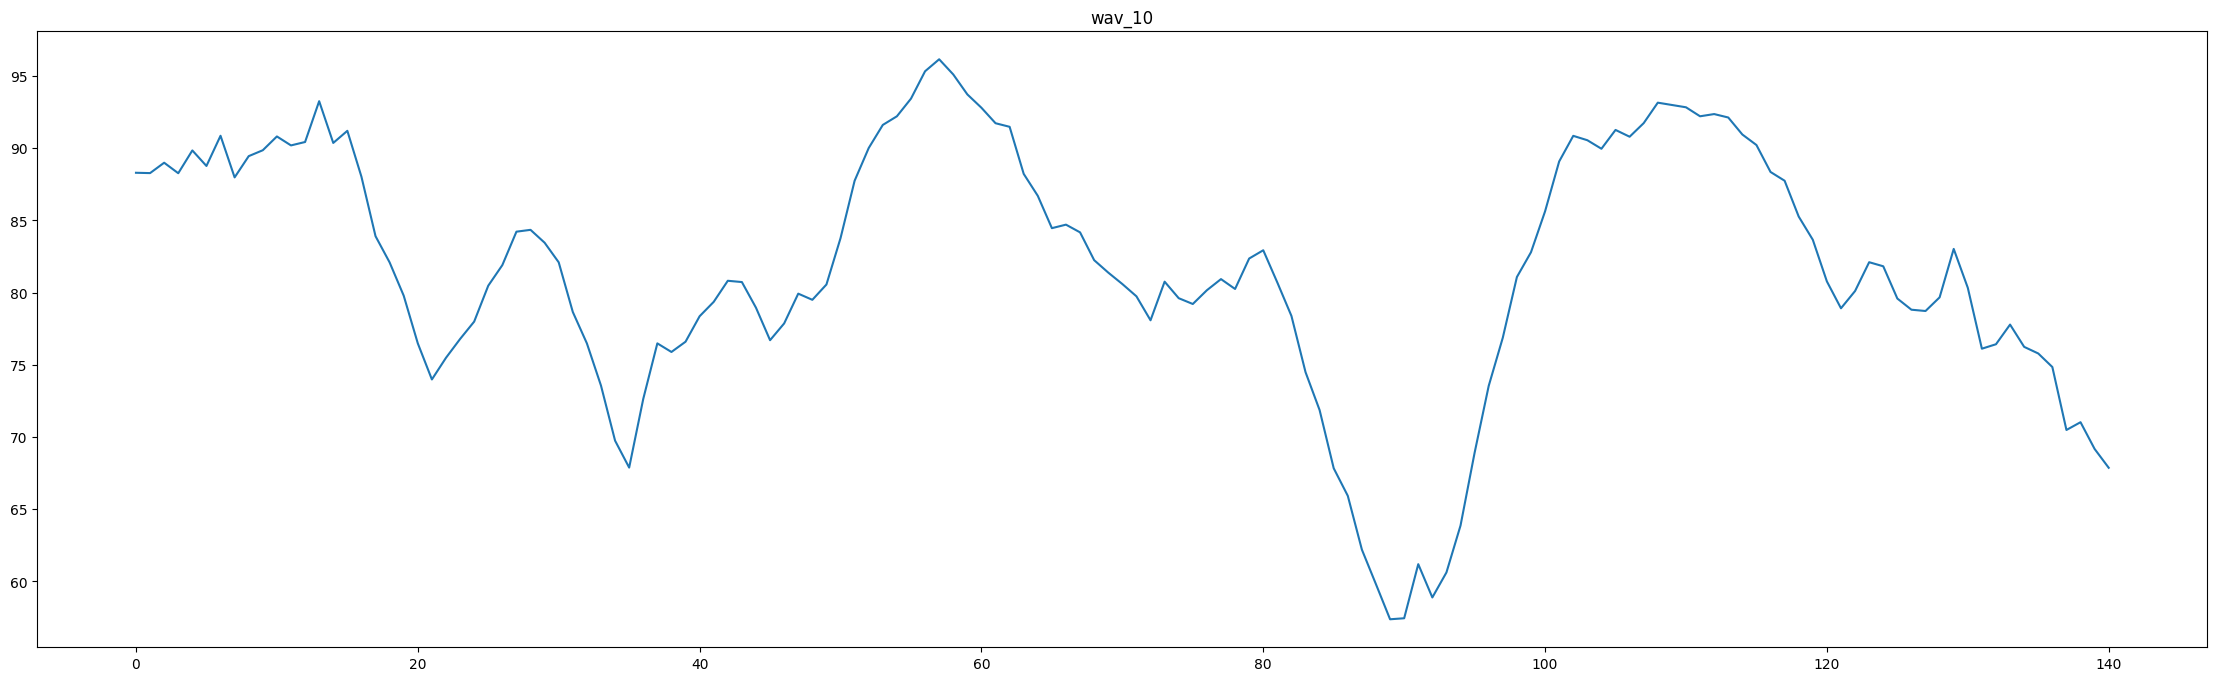

In [12]:
rms_wave_list = []
rms_time_list = []
fs_rms_list = []

for j,i in enumerate(spec_wave_list):
    rms_wave = librosa.feature.rms(i, frame_length=64, hop_length=8, center=False)
    
    N_rms = len(rms_wave.ravel()) # 標本データ数(要素数)を返す
    L_rms = spec_wave_time[j][-1] # 時間(長さ)の算出
    x_rms = np.linspace(0, L_rms, N_rms)
    fs_rms = 1/(L_rms/N_rms)
    
    rms_wave_list.append(rms_wave.ravel())
    rms_time_list.append(x_rms)
    fs_rms_list.append(fs_rms)
    
    fig, ax = plt.subplots(figsize=(28, 8))
    plt.plot(rms_wave.ravel())
    ax.set_title(j)
    #ax.set_xticks(np.arange(0, plot_time[-1], 0.5))
    plt.title("wav_"+str(j+1))
    plt.show()

## 平均による平滑化信号算出

141
191
191
191
191
191
141
141
141
141


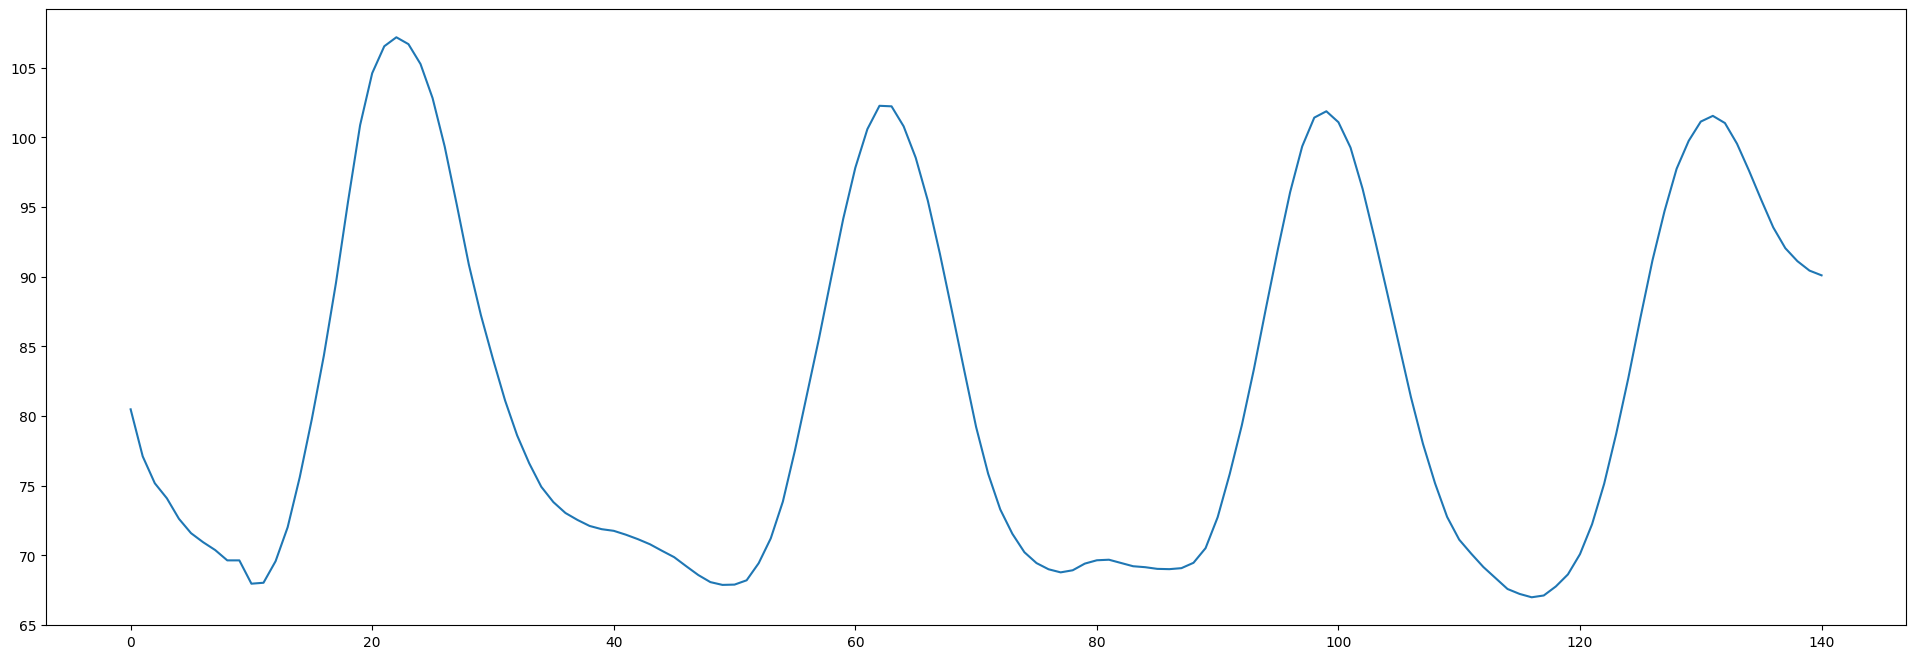

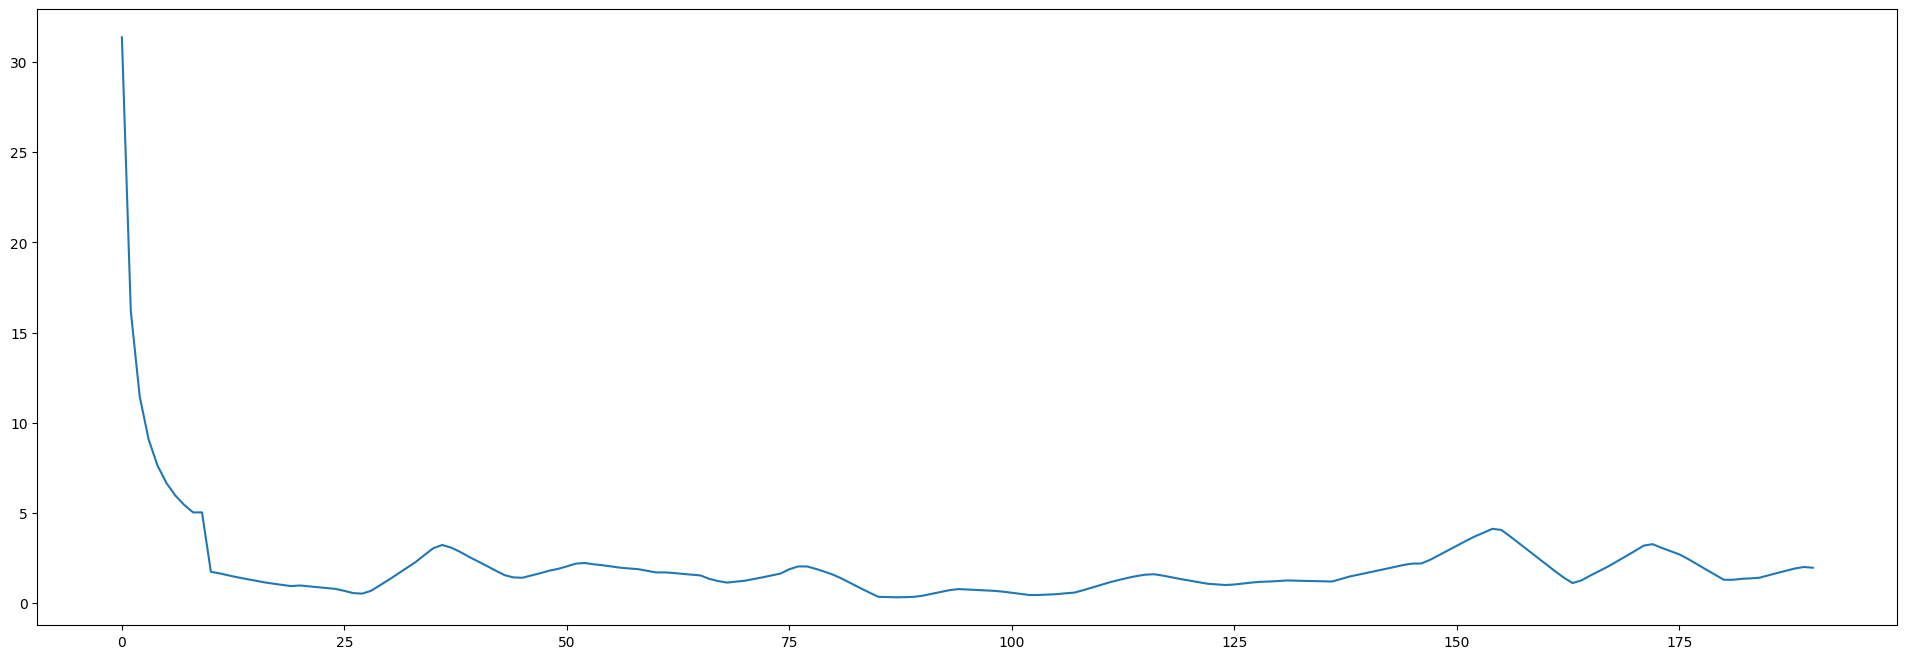

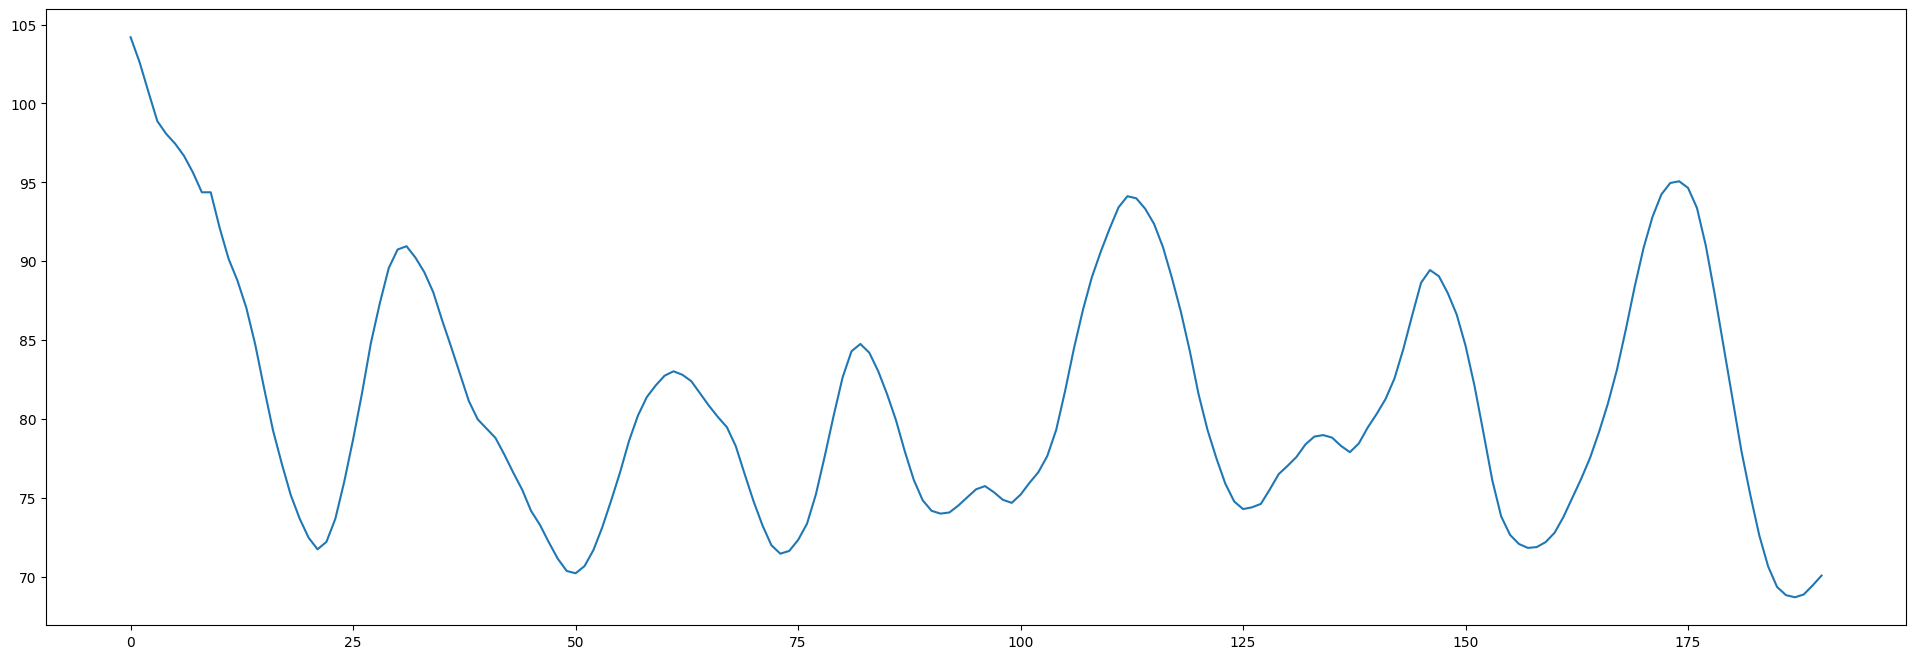

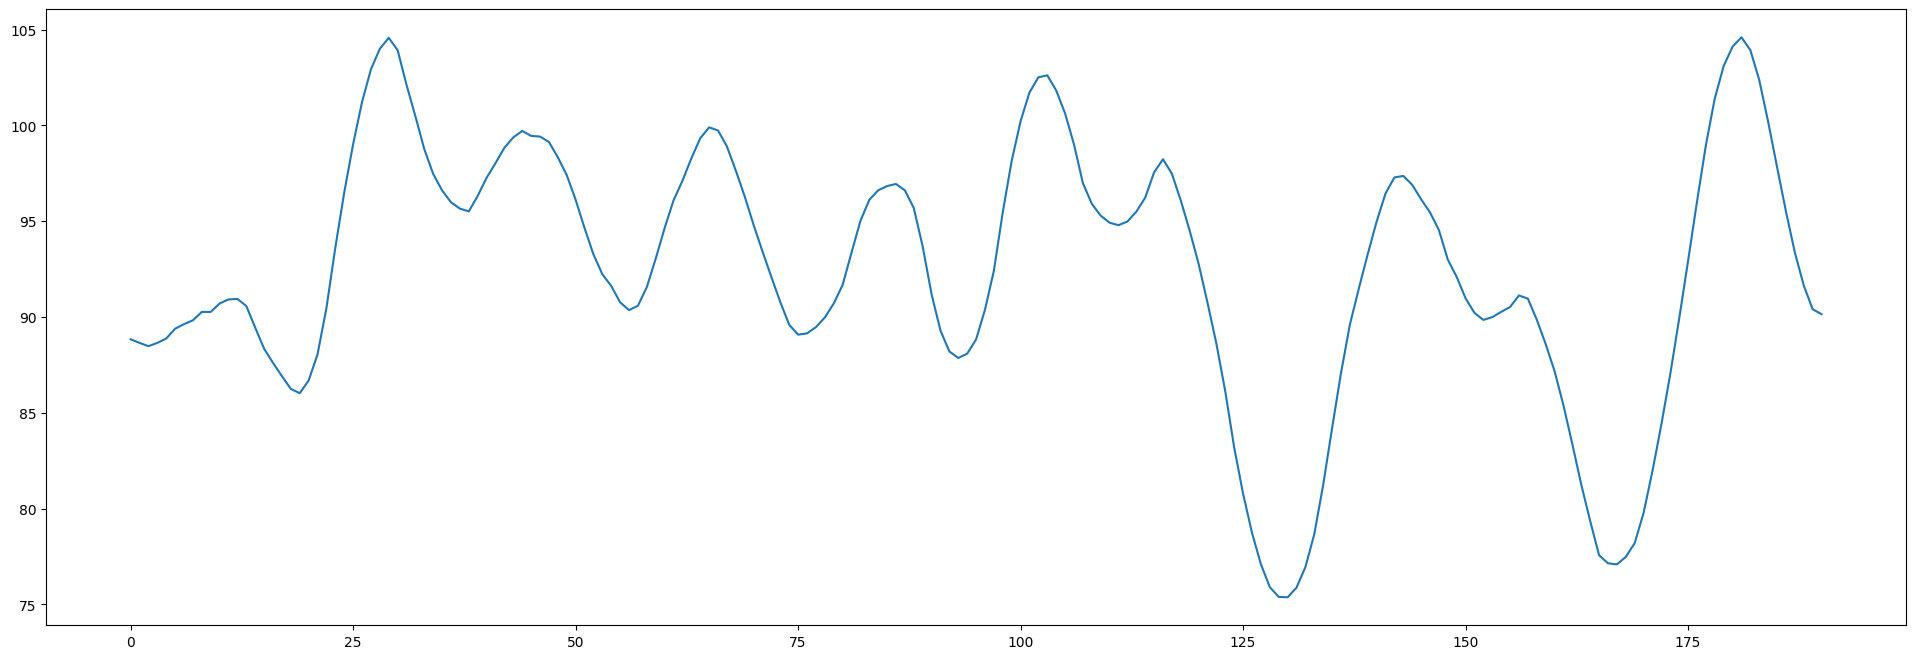

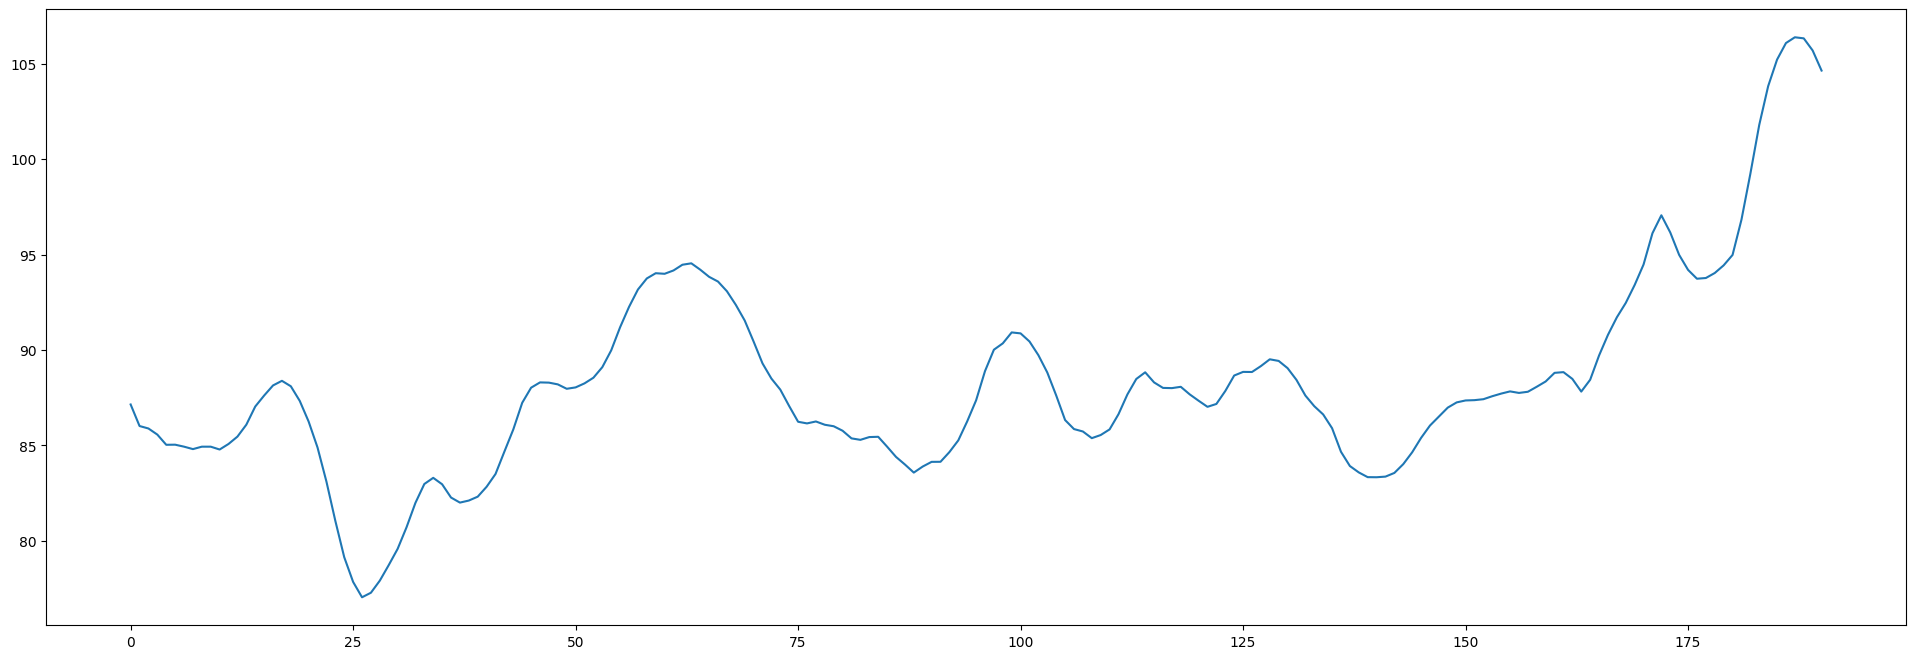

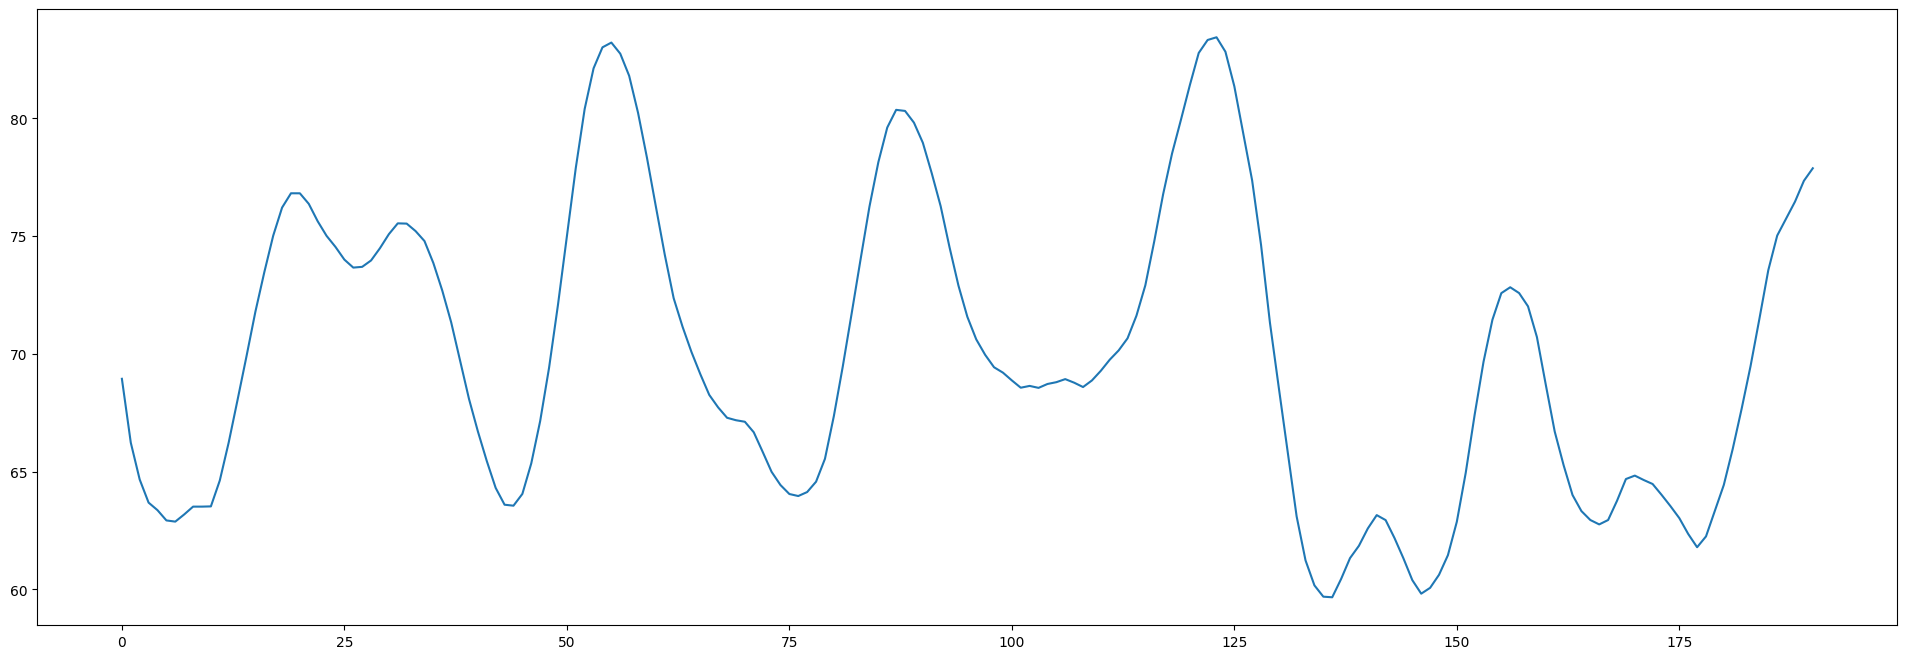

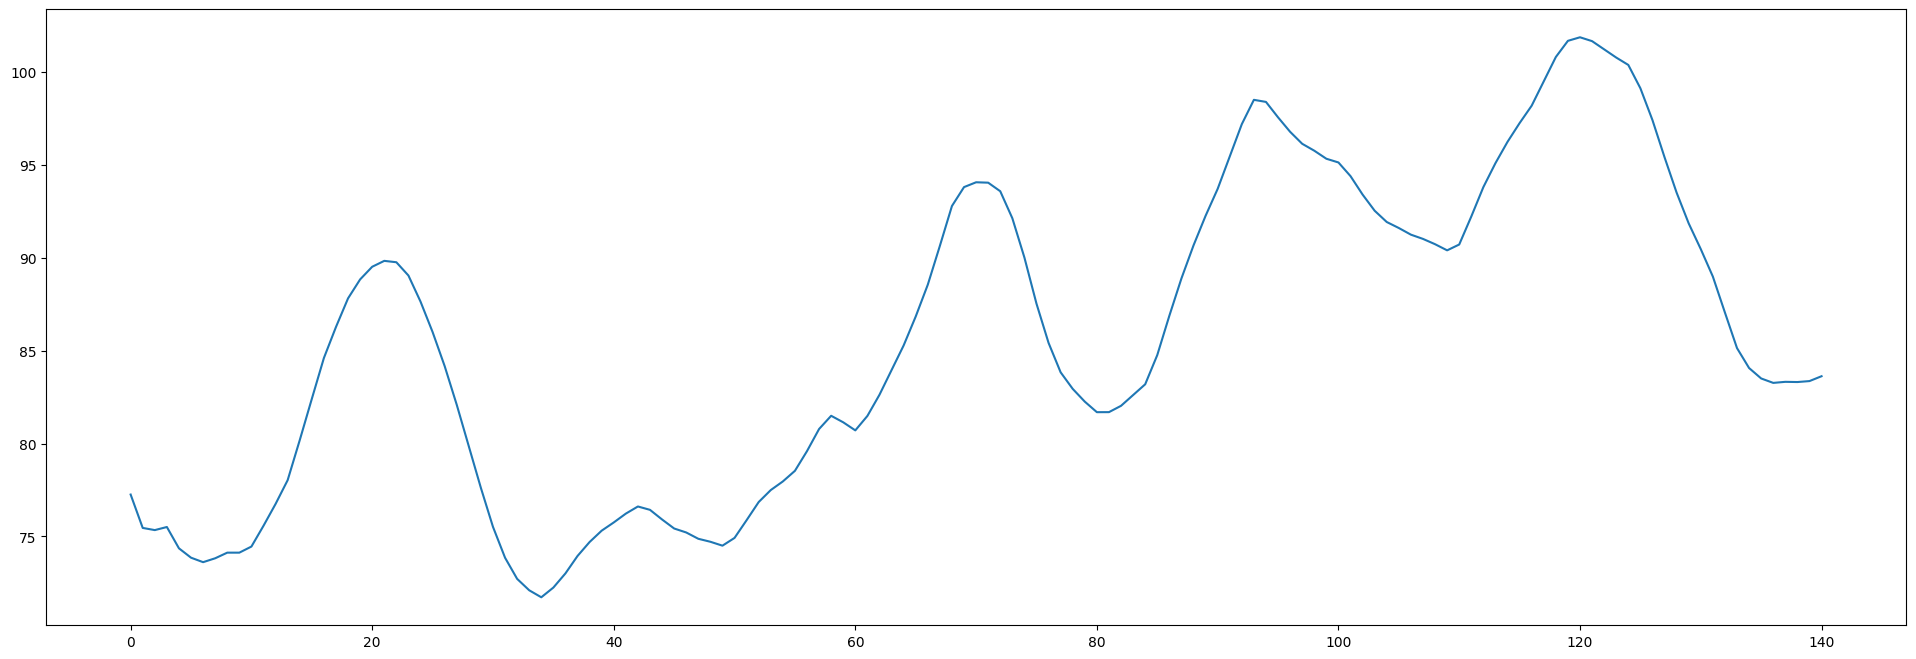

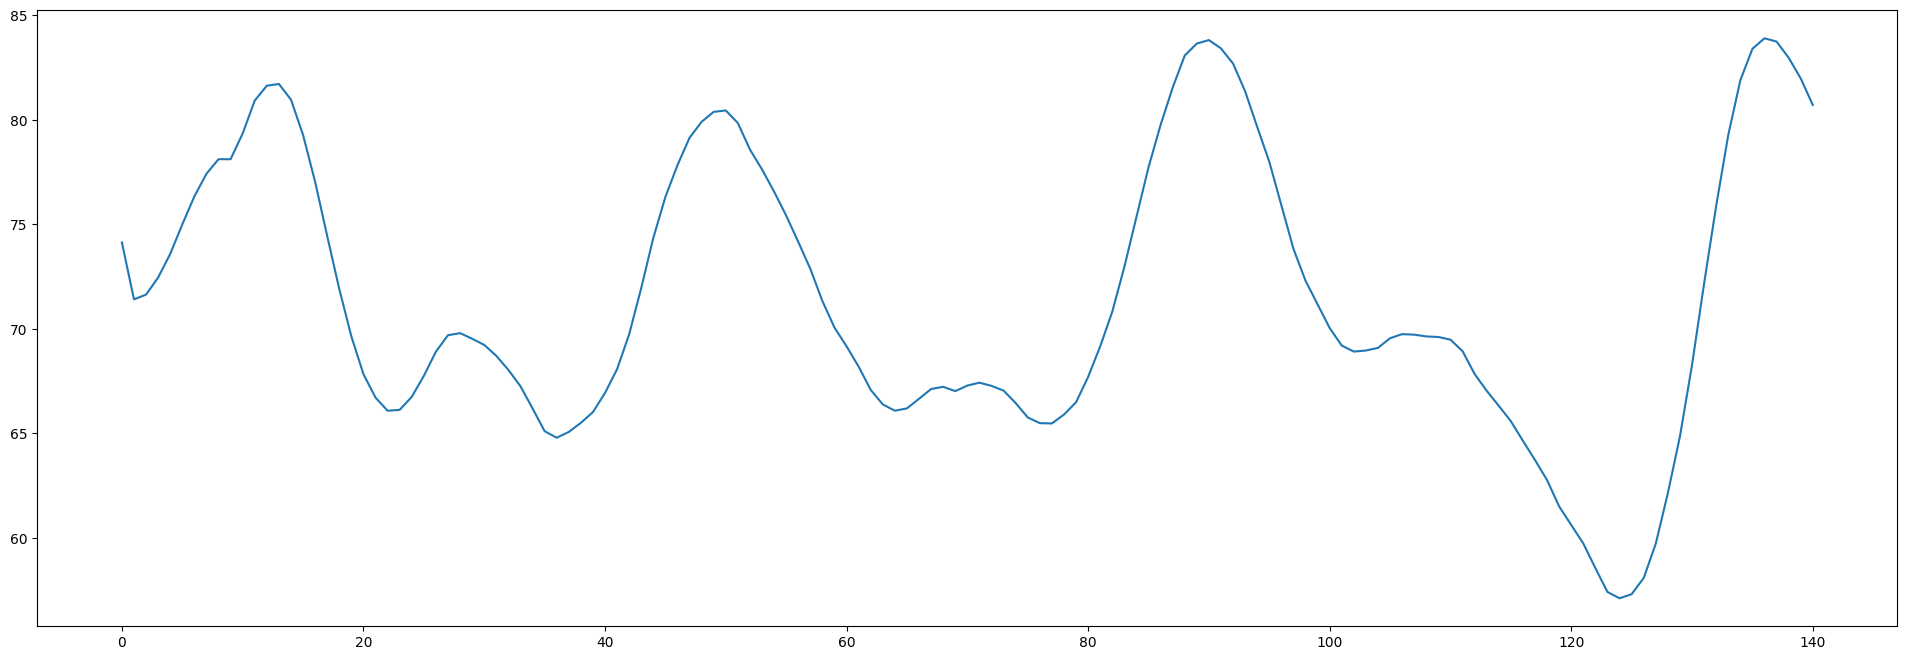

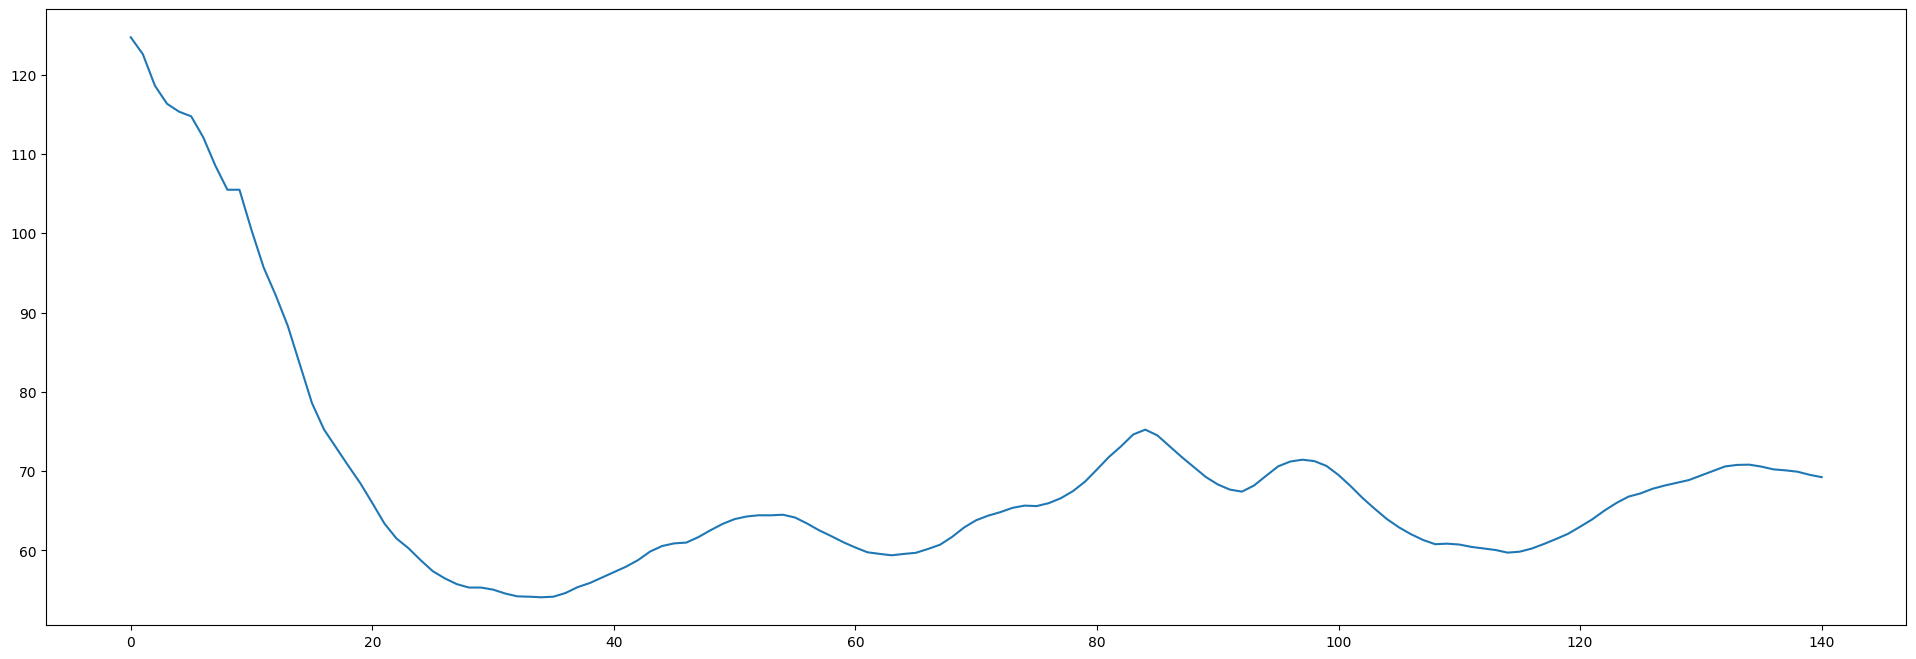

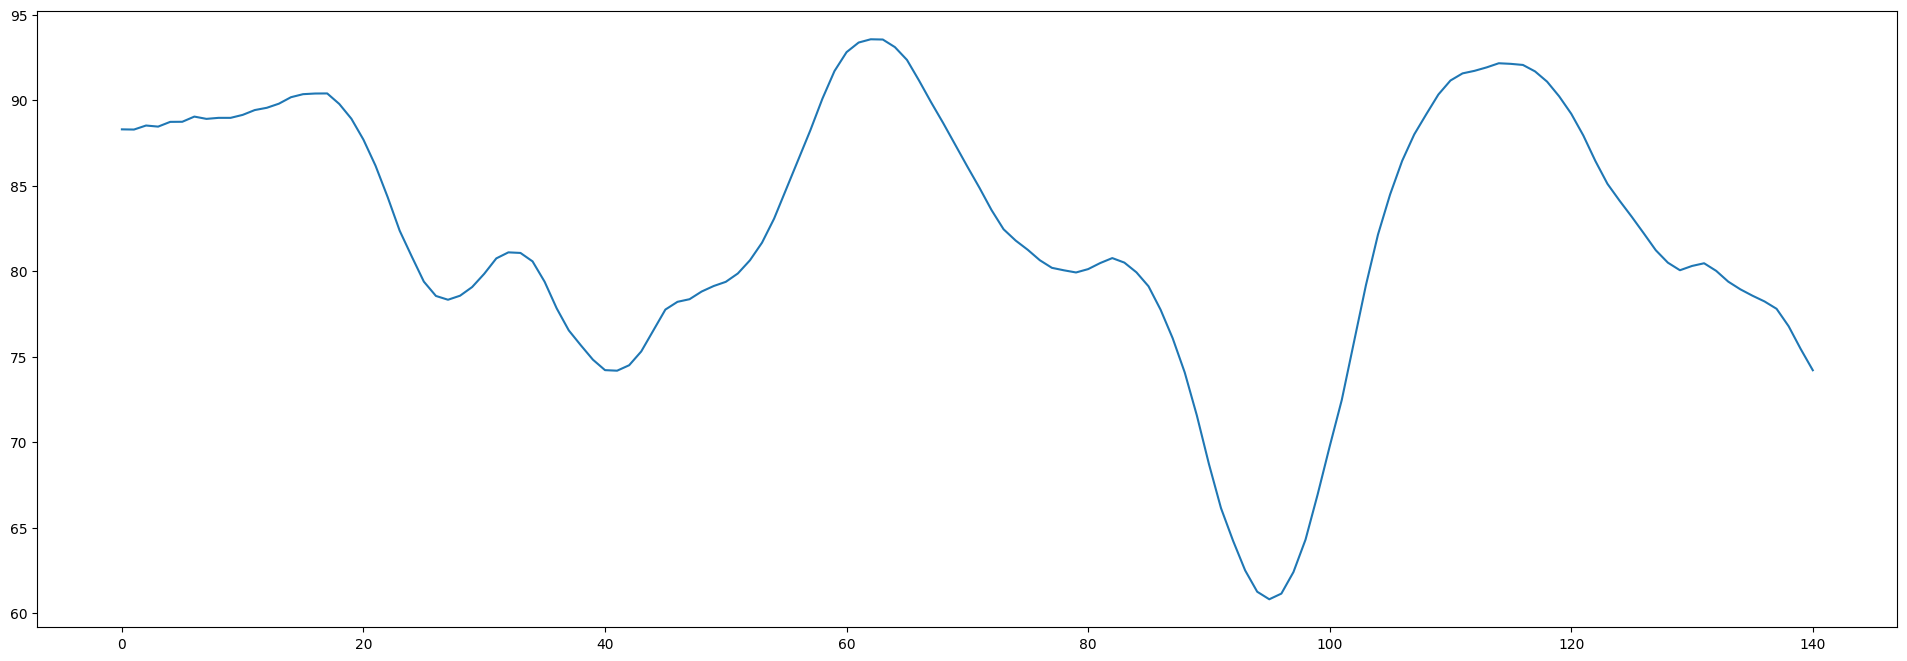

In [13]:
mean_rms_list = []                                                   ##全データのrms平均平滑化信号格納リスト

for index in range(len(wav_files)):
    rms_sample_num = rms_wave_list[index].shape[0]                   ##rms信号全体時間のの標本数
    rms_sample_rate = fs_rms_list[index]                             ##rms信号のサンプリング周波数
    second_sample = int(rms_sample_rate)                                ##rms信号の1秒間の標本数
    mean_rms = []                                                    ##rms信号の1秒間の平均平滑化信号
    
    for i in range(len(rms_wave_list[index])):
        
        ##最初の1秒以降
        if i >= second_sample:
            mean = rms_wave_list[index][i-second_sample:i].mean()
        ##最初の1秒以前
        else:
            mean = rms_wave_list[index][0:i+1].mean()
        mean_rms.append(mean)
    print(len(mean_rms))
    mean_rms_list.append(mean_rms)
    
    
for j in range(len(wav_files)):
    fig, ax = plt.subplots(figsize=(24, 8))
    plt.plot(mean_rms_list[j])

## 平均差分信号算出

141
191
191
191
191
191
141
141
141
141


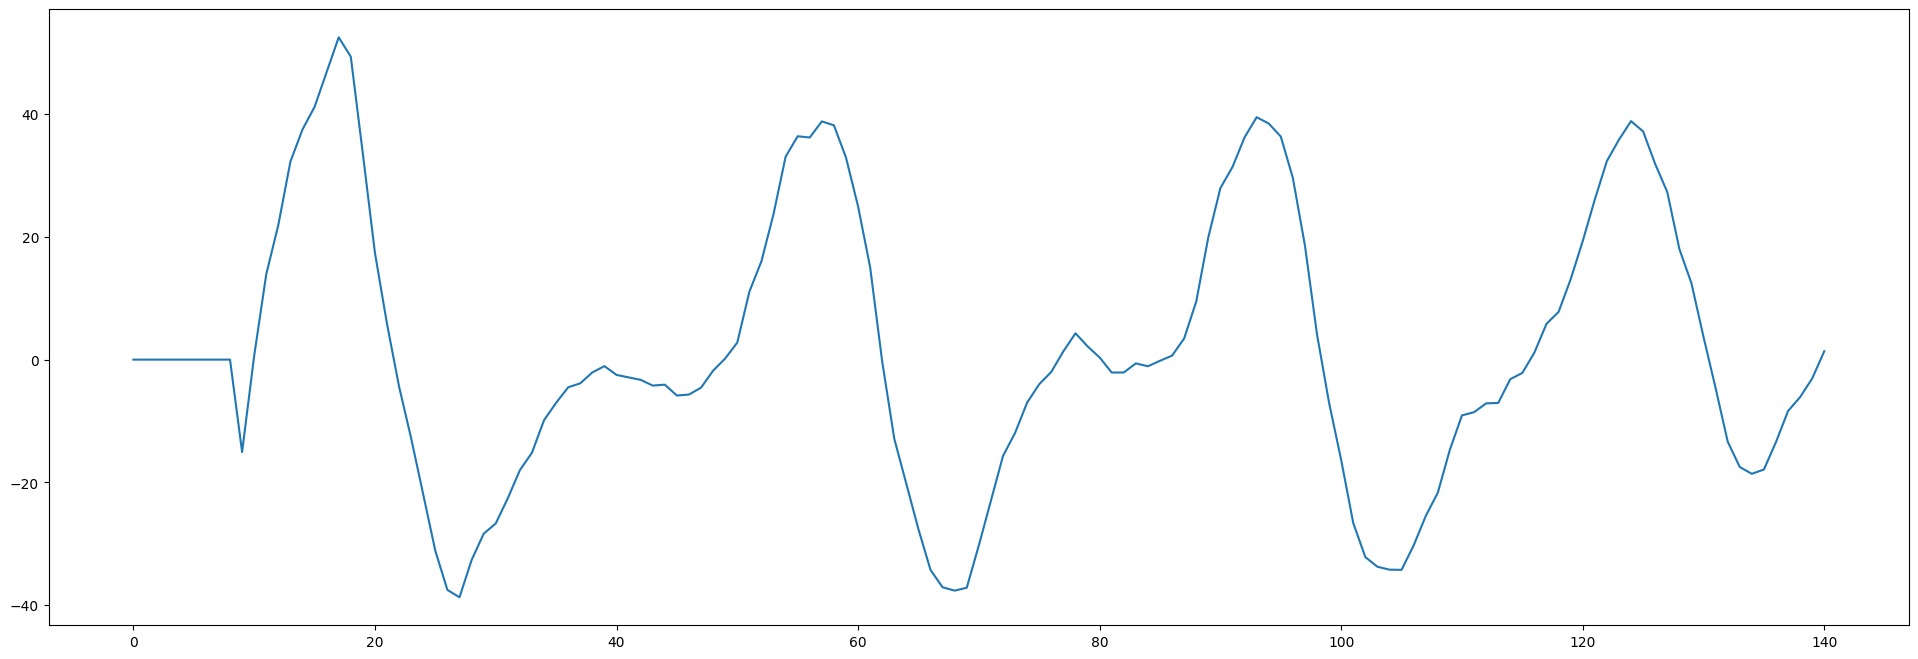

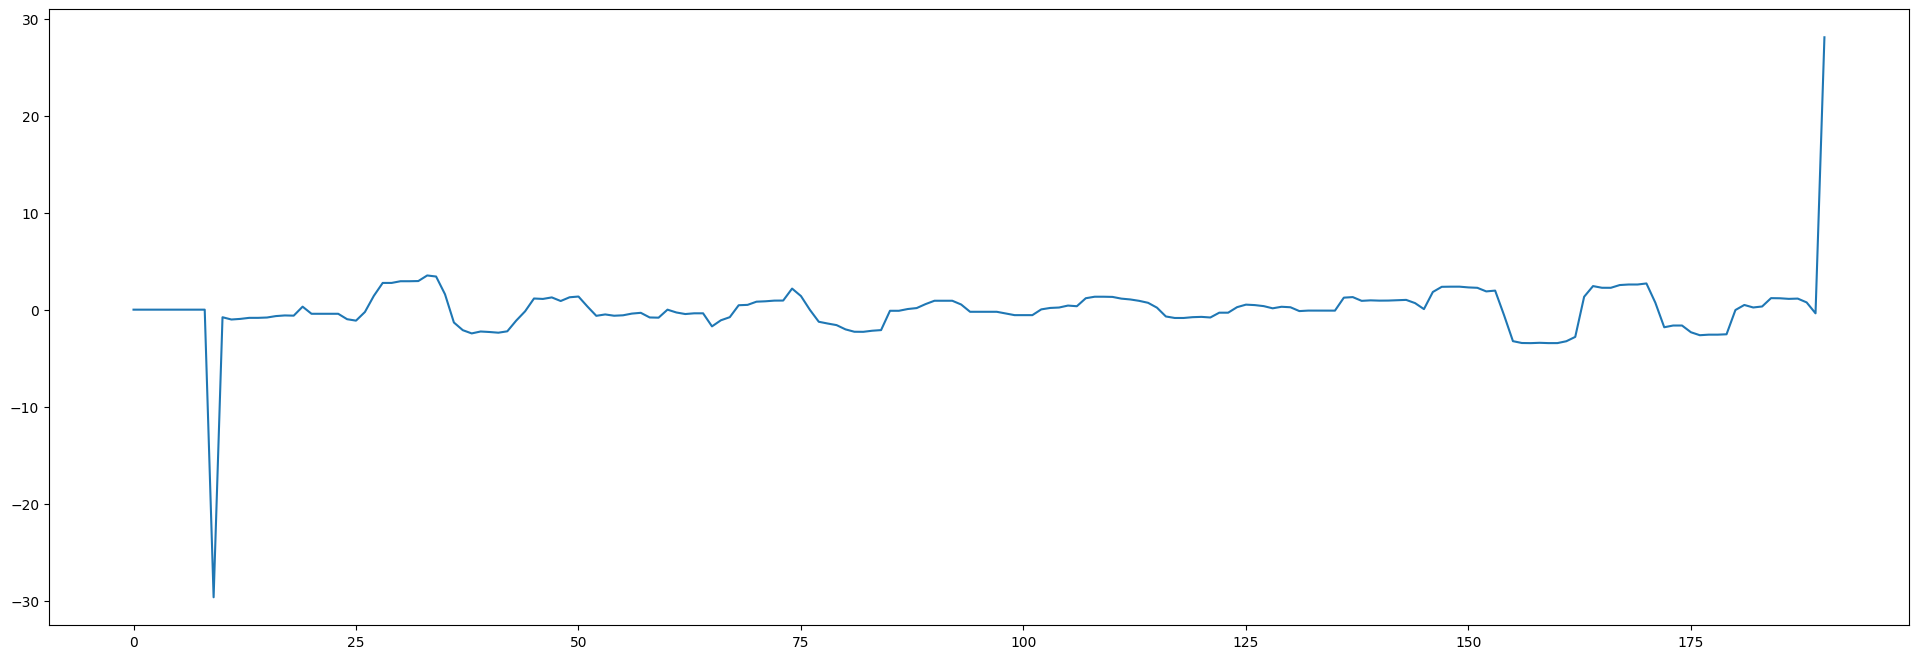

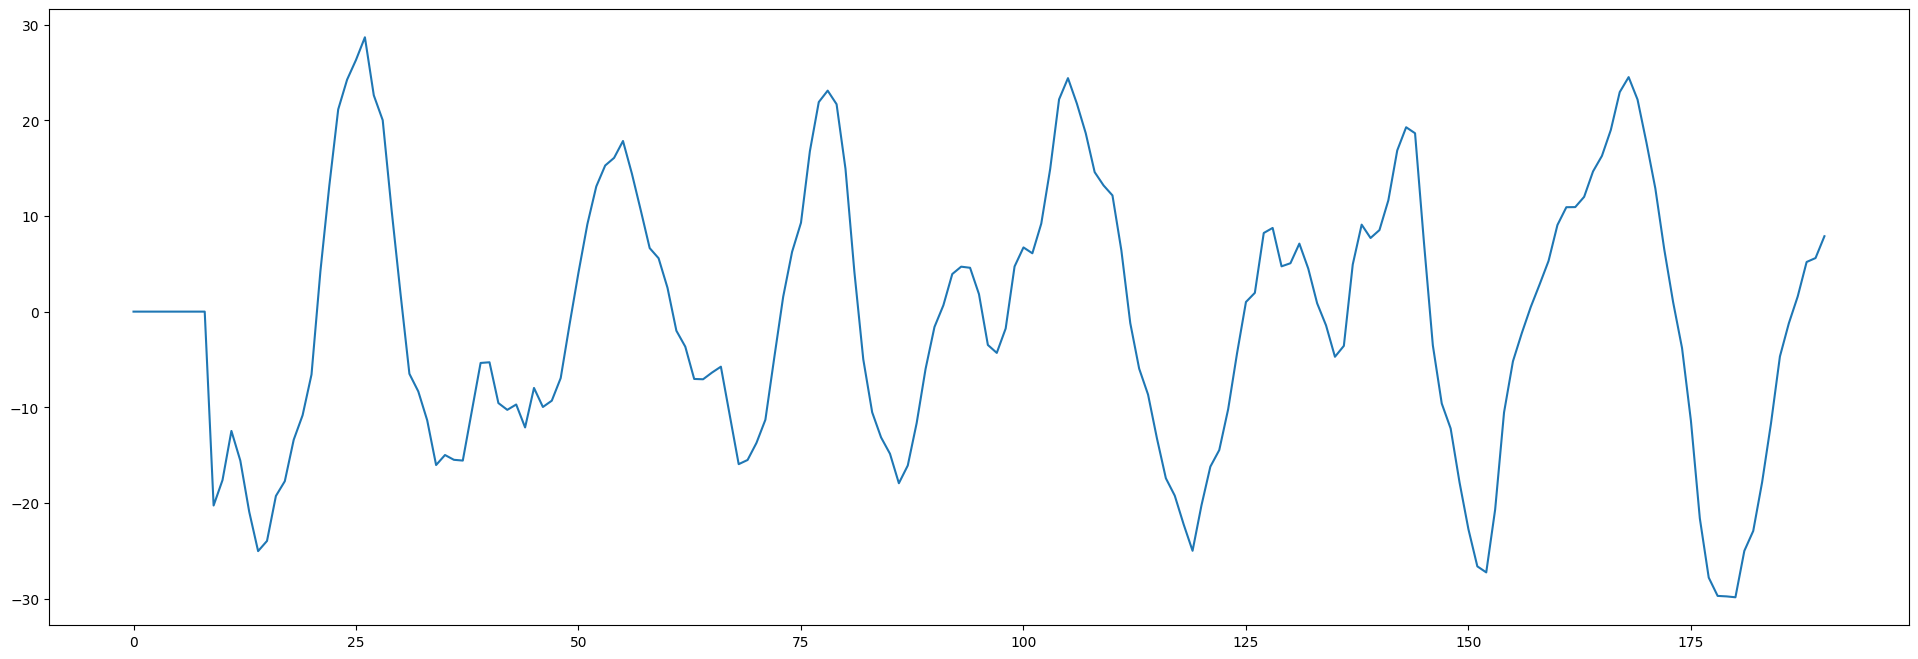

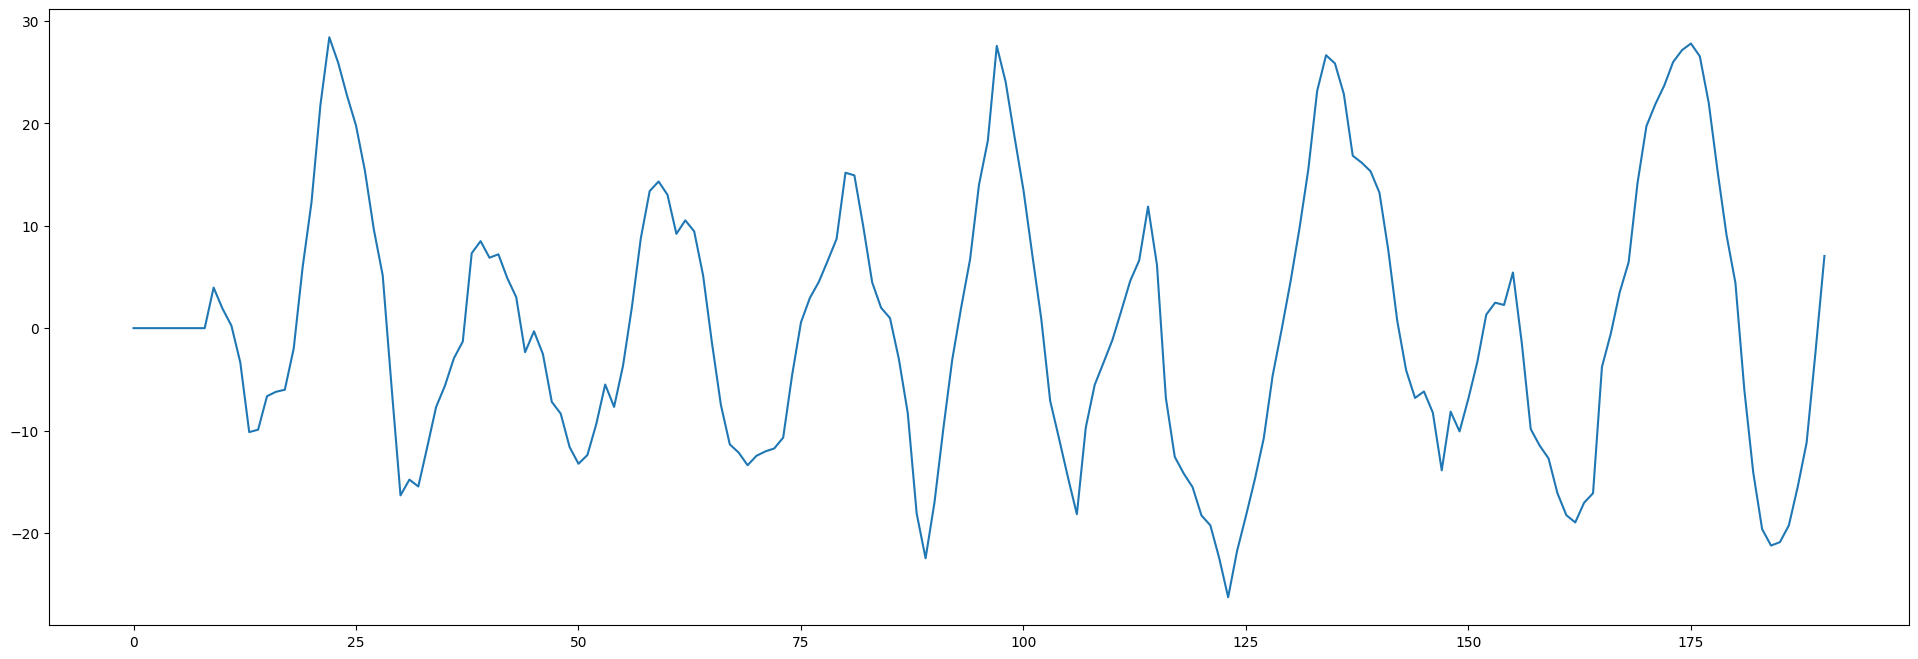

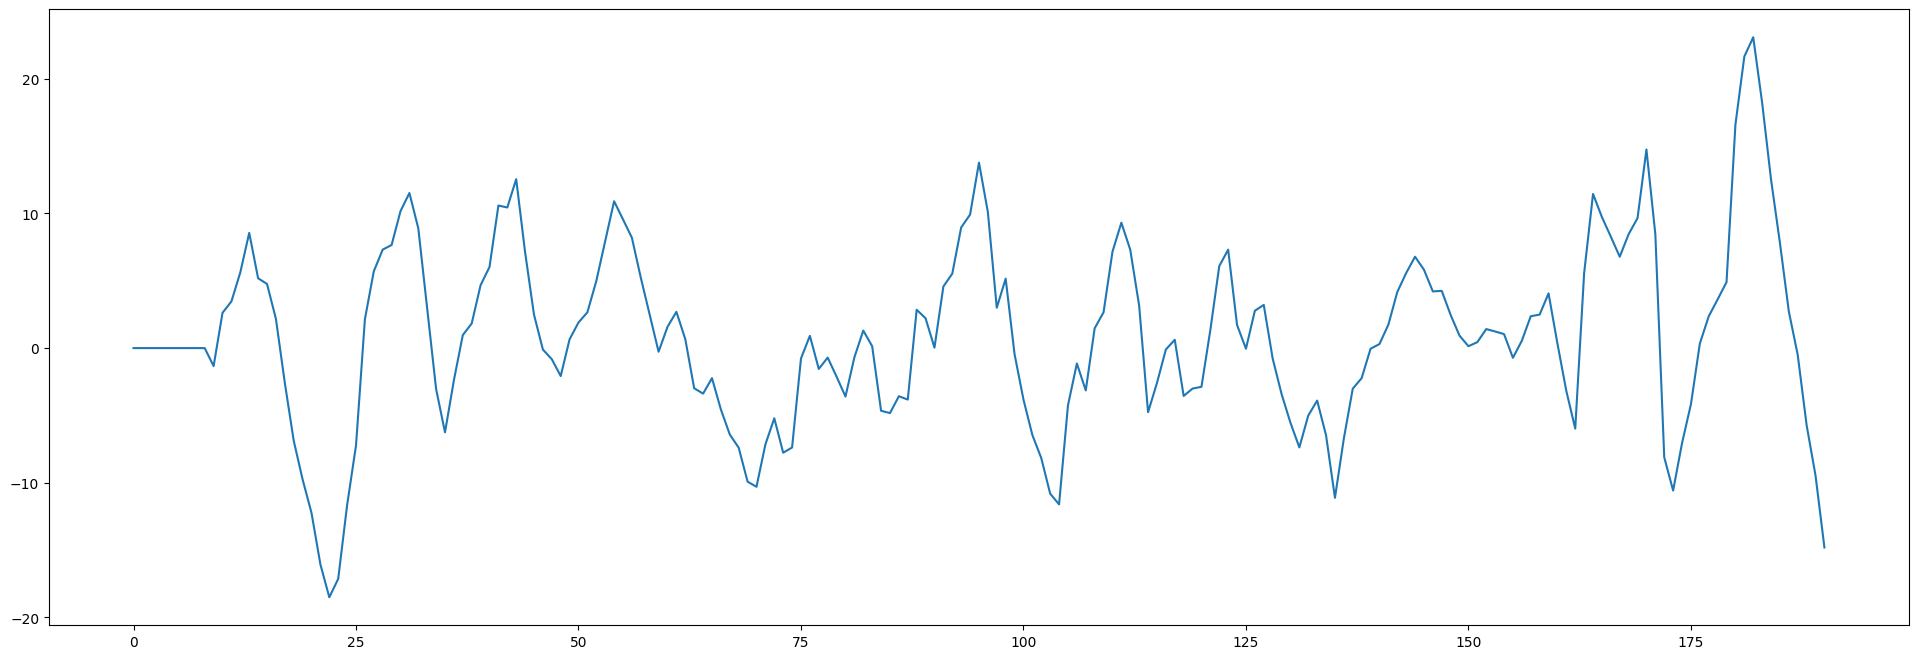

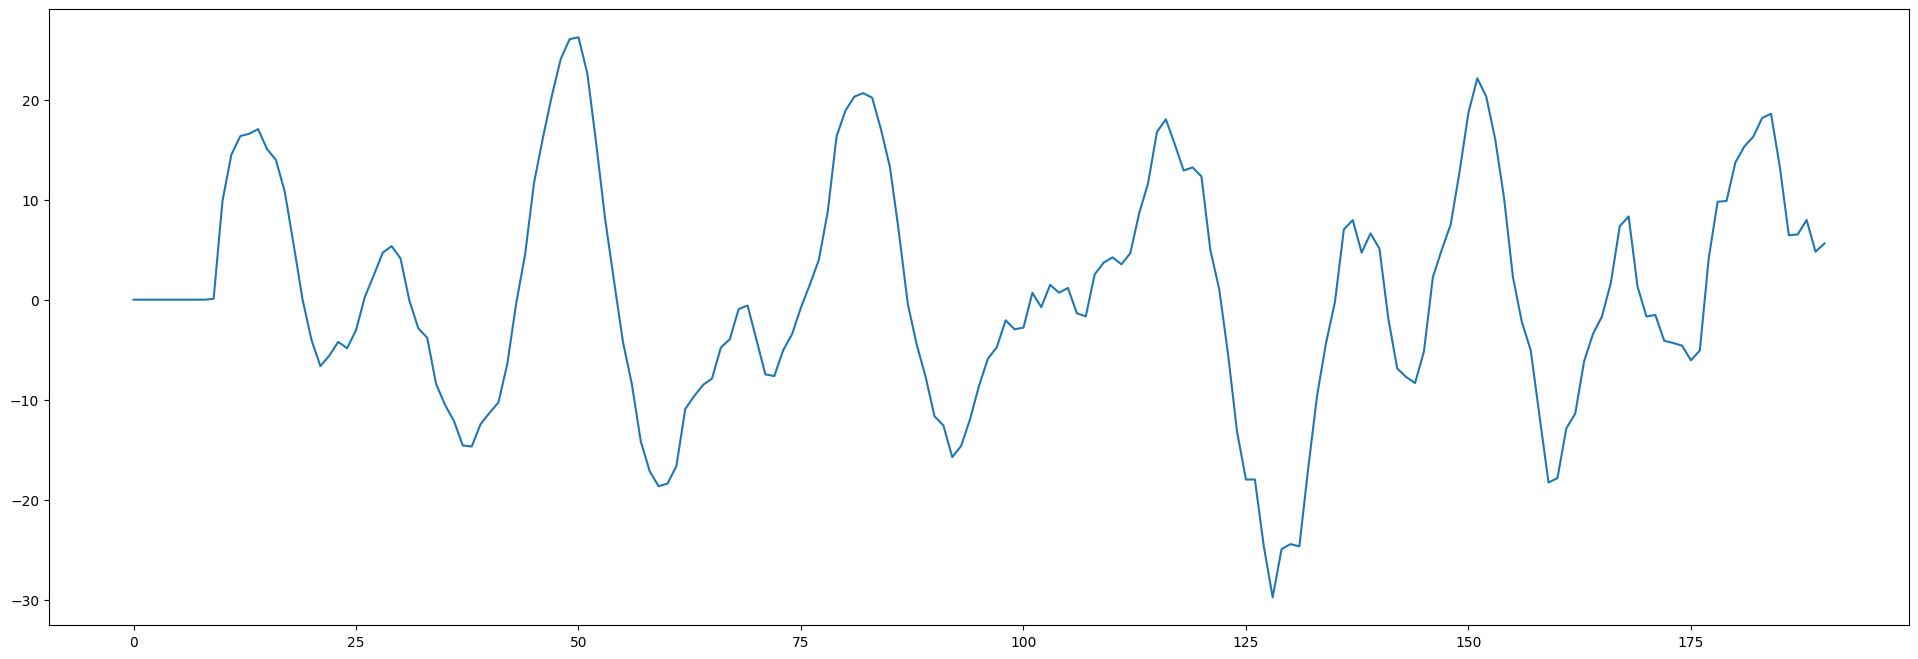

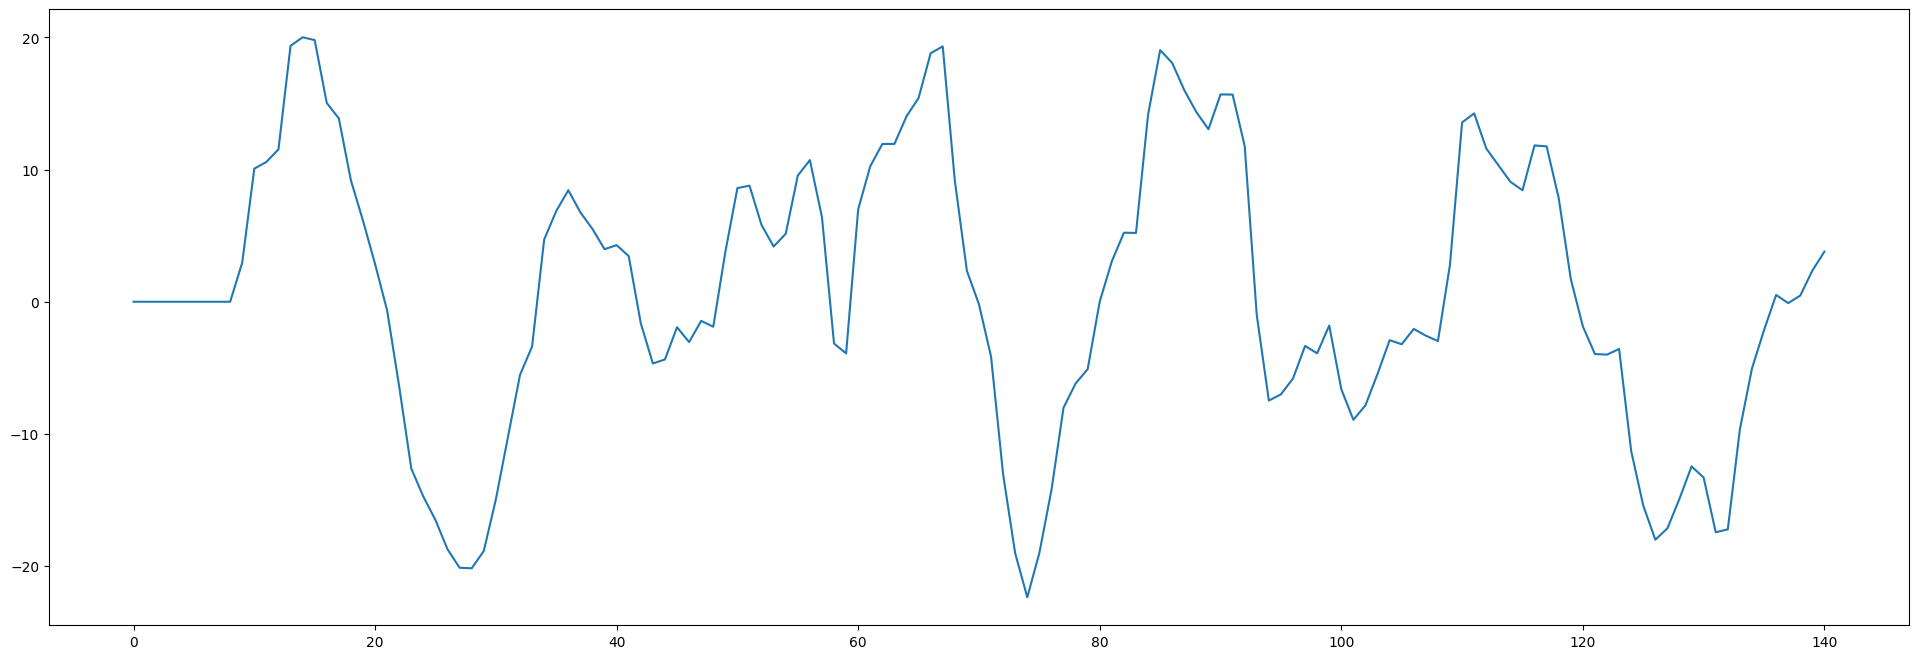

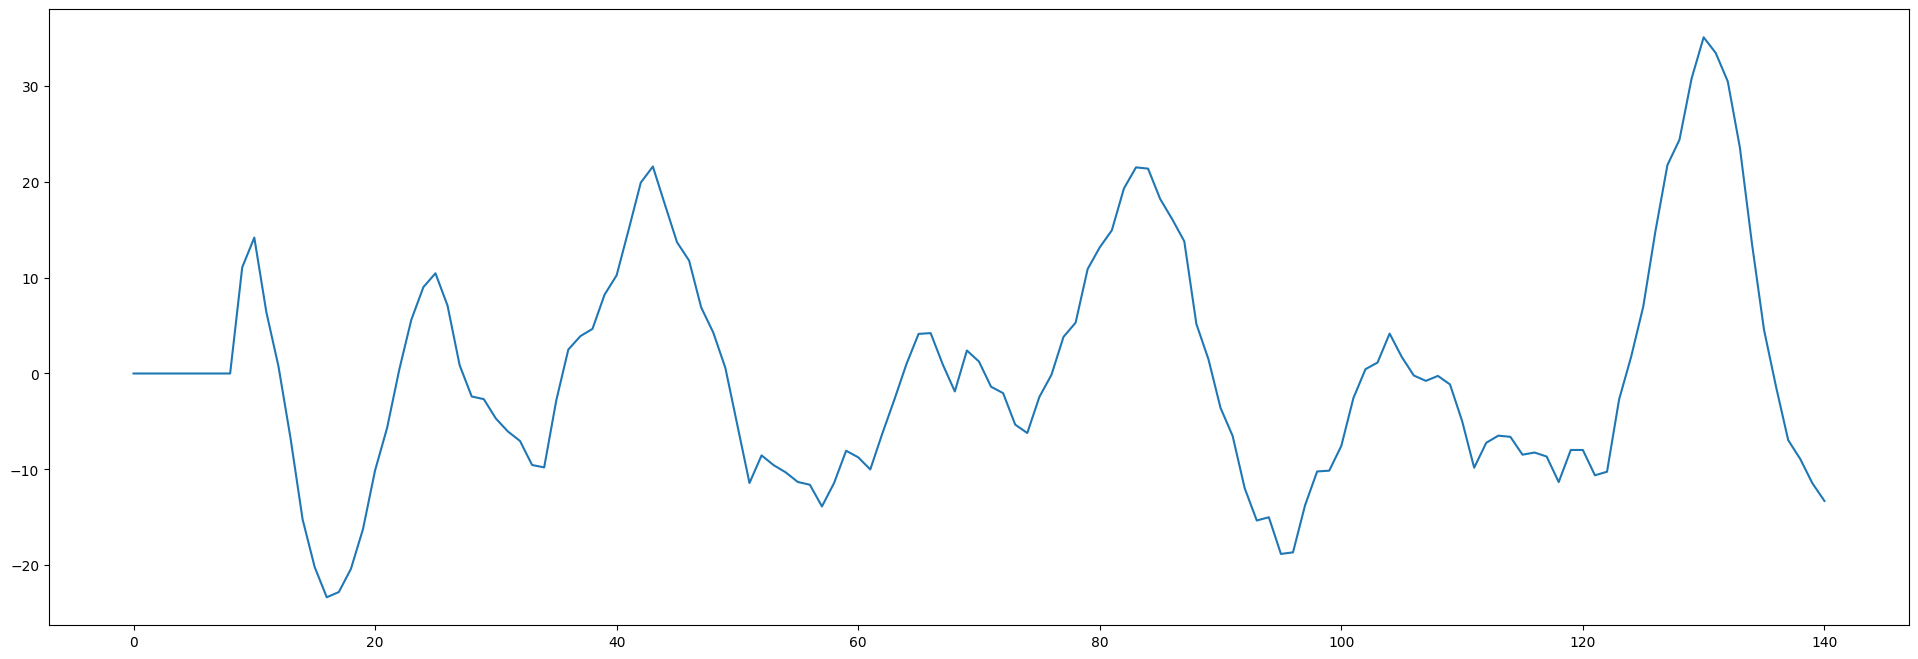

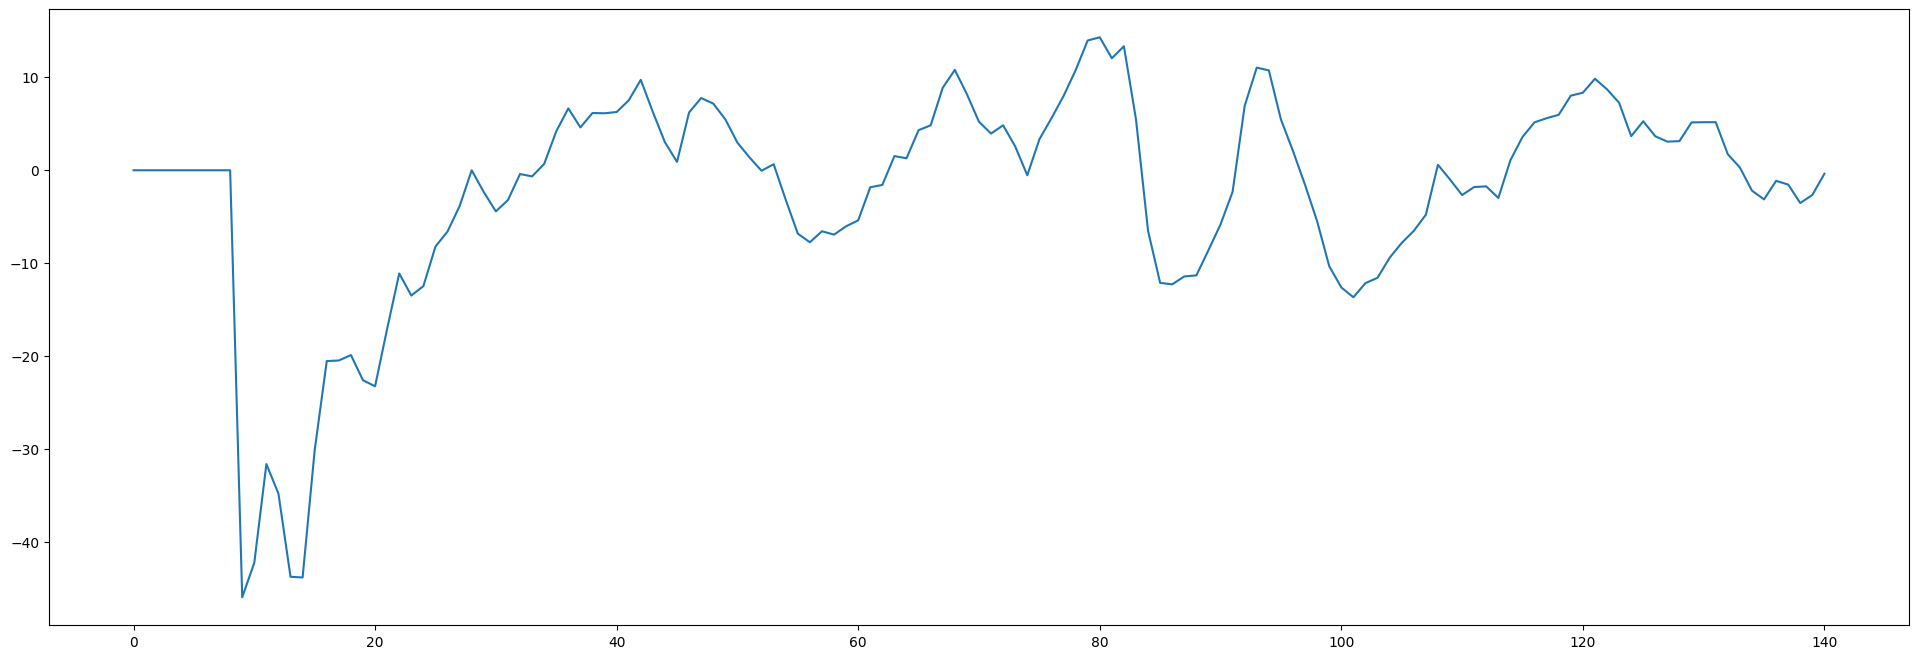

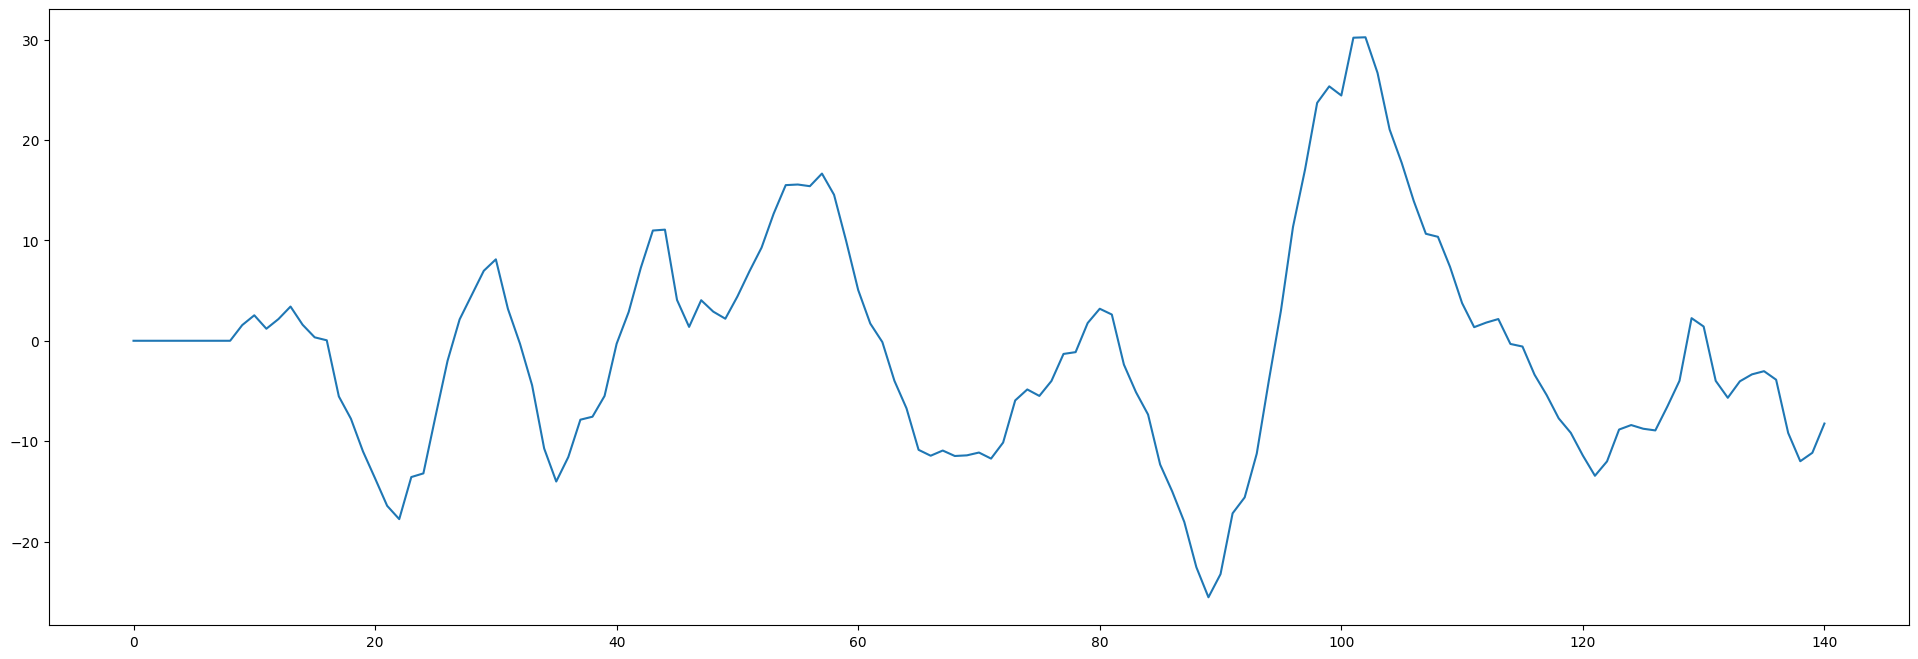

In [14]:
diff_rms_list = []                                                   ##全データのrms平均差分信号格納リスト

for index in range(len(wav_files)):
    rms_sample_num = rms_wave_list[index].shape[0]                   ##rms信号全体時間のの標本数
    rms_sample_rate = fs_rms_list[index]                             ##rms信号のサンプリング周波数
    second_sample = int(rms_sample_rate)                                ##rms信号の1秒間の標本数
    diff_rms = []                                                    ##rms信号の1秒間の平均差分信号
    
    for i in range(len(rms_wave_list[index])):
        
        ##最初の1秒以降
        if i >= second_sample:
            diff = rms_wave_list[index][i]-rms_wave_list[index][i-second_sample]
        ##最初の1秒以前
        else:
            diff = rms_wave_list[index][i]-rms_wave_list[index][i]
        diff_rms.append(diff)
    print(len(diff_rms))
    diff_rms_list.append(diff_rms)
    
for j in range(len(wav_files)):
    fig, ax = plt.subplots(figsize=(24, 8))
    plt.plot(diff_rms_list[j])

In [15]:
print(len(mean_rms_list[0]))
print(len(diff_rms_list[0]))
print(len(rms_wave_list[0]))

141
141
141


## 隠れマルコフモデル(HMM)による呼吸相検出プログラムの作成
### RMS・平均・差分の特徴量を用いた隠れマルコフモデル

In [281]:
num = 7

'''
column = ['rms','mean','diff']
df = pd.DataFrame(
    data={'rms': rms_wave_list[num], 
              'mean': mean_rms_list[num],
              'diff': diff_rms_list[num]}
    )
'''

df_r = pd.DataFrame(
    data={'rms': rms_wave_list[num]}
    )

column = ['diff']
df = pd.DataFrame(
    data={'diff': diff_rms_list[num]}
    )


'''
df_r = pd.DataFrame(
    data={'rms': rms_wave_list[num]}
    )

column = ['mean']
df = pd.DataFrame(
    data={'mean': mean_rms_list[num]}
    )
'''

df

diff
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
..         ...
136  -1.417290
137  -6.946716
138  -8.921623
139 -11.437744
140 -13.289810

[141 rows x 1 columns]

### 標準化

In [282]:
#標準化インスタンスを作成
sc = StandardScaler()
#df_tmpを標準化
df_std = sc.fit_transform(df)
#データフレーム型に変換
df_std = pd.DataFrame(df_std, columns=df.columns)

### 平均データ

In [283]:
#標本ごとの平均データ

avgrms = df_r[["rms"]]
avgrms_std = df_r[["rms"]]


### 隠れマルコフモデルの作成

In [284]:
model_all = hmm.GaussianHMM(n_components=3, covariance_type="full", random_state=0)

### モデルの学習

In [285]:
#モデルの学習
#問1-2：観測値には月ごとの平均気温、降水量、アイスクリーム生産量のデータを使う
model_all.fit(df_std)
hidden_states = model_all.predict(df_std)

## 結果の視覚化

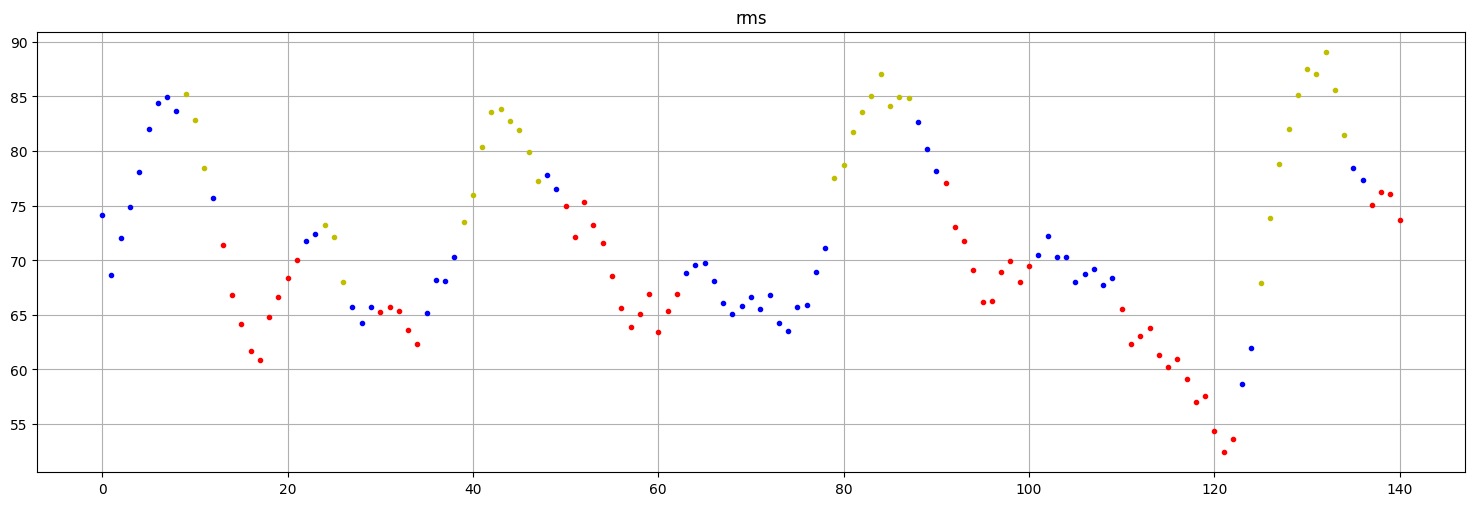

In [286]:
#結果を表示してみる
colors = ["b","y","r","g","c","k"]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()

plt.grid(True)
plt.tight_layout()
plt.title("rms")

for i,color in enumerate(colors):# それぞれの隠れ状態を描画
    mask = hidden_states != i # 目的の隠れ状態じゃないのをマーク
    tmp = avgrms_std.copy() # 表示するデータをコピー
    tmp[mask] = None # マークした目的の隠れ状態ではない点を描画しない
    plt.plot(tmp,".",c=color)

## 状態遷移系列の表示

In [287]:
def hmm_plot(data,hmm_time,model_hmm,last_time):
    #### 状態系列を格納
    stateSequence = model_hmm.predict(data)
    #### 描画
    fig, ax = plt.subplots(figsize=(24, 8))
    plt.plot(hmm_time ,stateSequence)
    plt.xlabel("time [sec]")
    plt.ylabel("state")
    plt.ylim(-0.5, 7.5)
    ax.set_xticks(np.arange(0, last_time, 0.5))
    #plt.xlim(0, 4)
    plt.show()

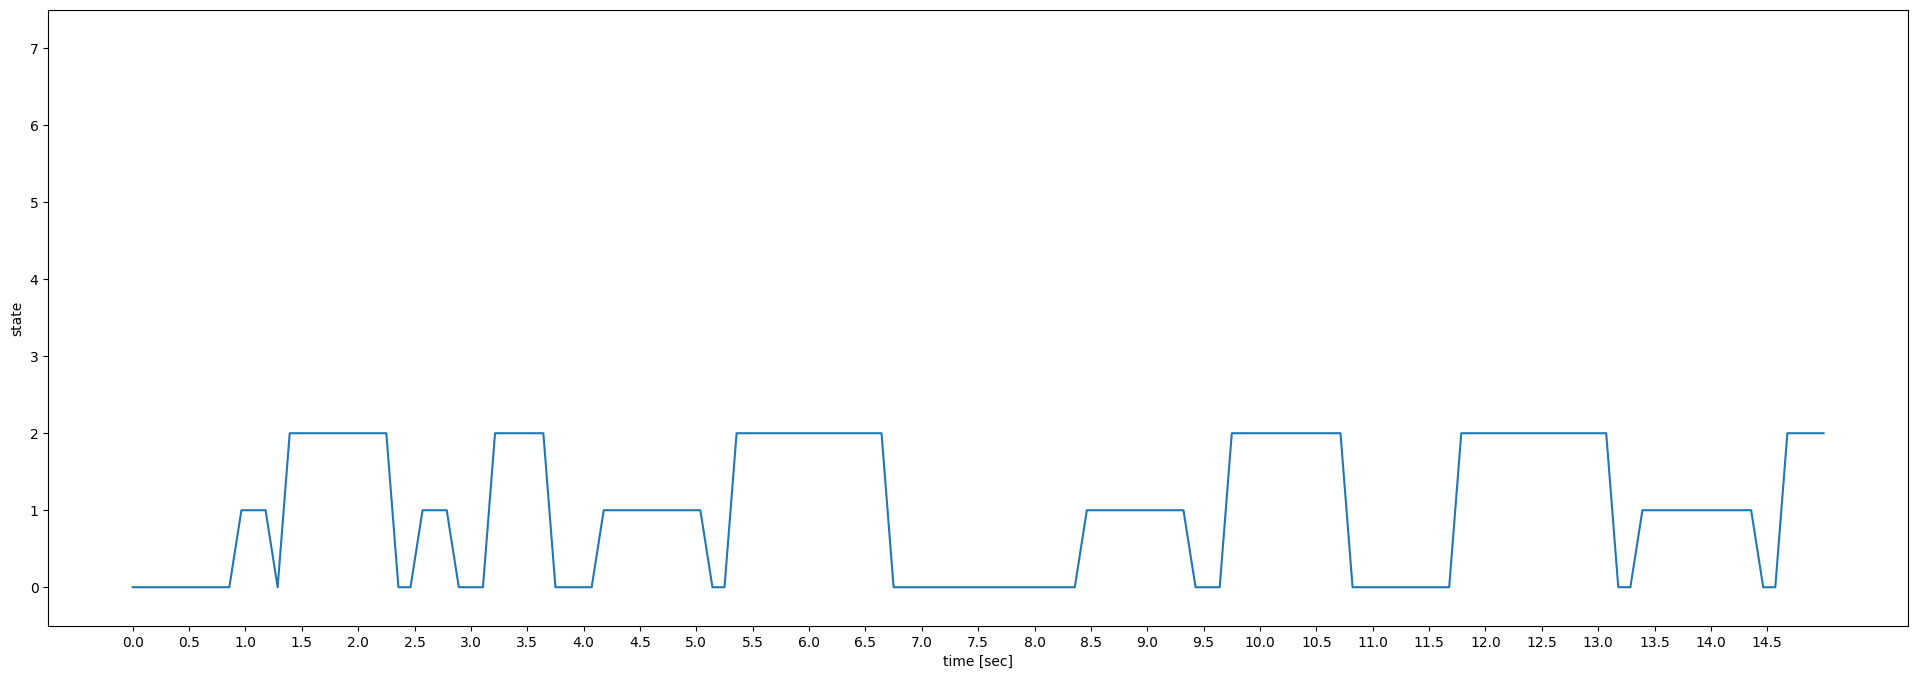

In [288]:
hmm_plot(data=df_std, hmm_time=rms_time_list[num], model_hmm=model_all, last_time=rms_time_list[num][-1] )

### 吸気状態を状態0に変換

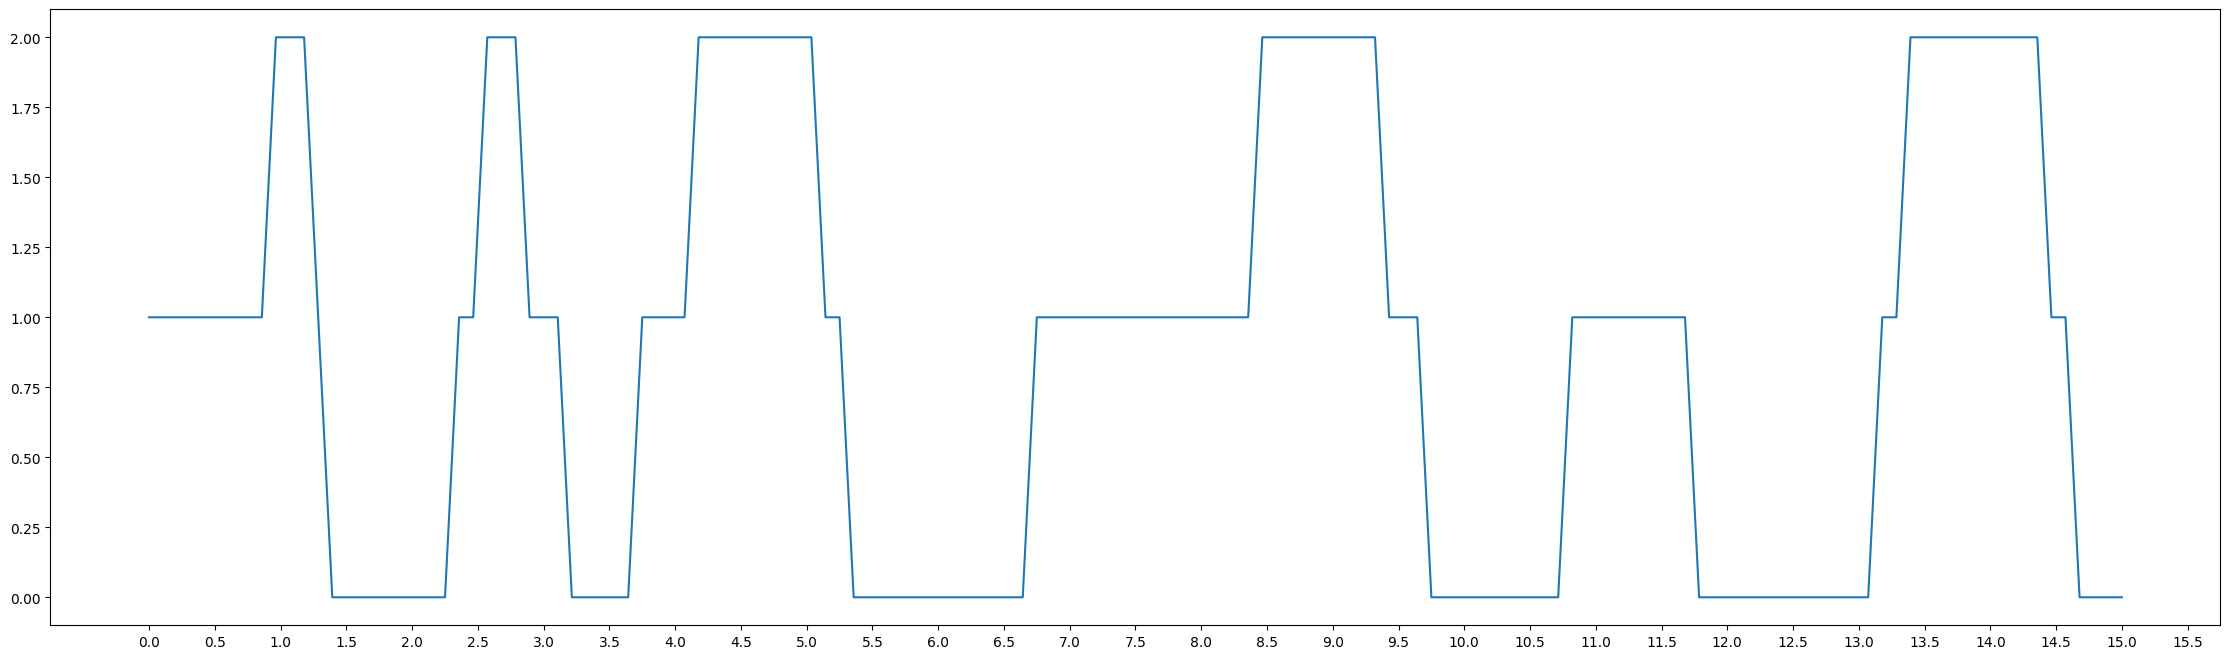

In [289]:
start_state = hidden_states[0]
state = []
min_ = 100000
max_ = -100000
max_index = 0
min_index = 0
data = avgrms_std["rms"].to_list()


for i in range(len(hidden_states)):
    if data[i] < min_:
        min_ = data[i]
        min_index = i
        
    if data[i] > max_:
        max_ = data[i]
        max_index = i
        
instate = hidden_states[max_index]
exstate = hidden_states[min_index]

'''
for i in range(len(hidden_states)):
    if hidden_states[i]!=start_state:
        peak_state = hidden_states[i]
        break
'''

for i in range(len(hidden_states)):
    if hidden_states[i] == exstate:
        state.append(0)
    elif hidden_states[i] == instate:
        state.append(2)
    else:
        state.append(1)

        
if len(hidden_states)==141:
    s = np.linspace(0.0,15.0,141)
else:
    s = np.linspace(0.0,20.0,191)
    
fig, ax = plt.subplots(figsize=(28, 8))
ax.set_xticks(np.arange(0, 20.0, 0.5))
ax.plot(s,state)
plt.show()

In [262]:
s = np.linspace(0.0,20.0,191)